# Predictive Model to determine the Diabetes underdiagnosed neighborhoods

## Goal

  To identify neighborhoods in California with a high risk of either underdiagnosed or poorly managed T2DM and/or asthma.

## Data 

* RTI Rarity database of over 200 variables in 10 domains of social drivers of health, demographics, and more for California
* AHRQ SDoH database for California at the tract level (it includes the whole US
* RTI SynthPop™ data for California
* Medical Expenditure Panel Survey (MEPS) data for the entire US

## AI LA Server Access Approach
Here are the steps to replicate: 
1. Log in with your user, for example:  ssh <user-name>@<ip-address> 
2. Type: pip install --user pipenv
3a. Make a project directory: mkdir -p ~/Projects/myst
3b. Copy the contents of /data to your project directory: cp -r /data/RTI_Rarity-AILA ~/Projects/myst 
4. Copy requirements.txt to project directory: cp /data/RTI_Rarity-AILA/requirements.txt ~/Projects/myst 
5. Make sure you are in your project directory: cd ~/Projects/myst 
6. Create virtual environment from home directory: pipenv run pip install -r requirements.txt
7. When the install finished, type: pipenv shell
8. You will see (username) in front of your prompt. 
9. Set a password for the notebook: jupyter notebook password
10. Start up the notebook: jupyter notebook --allow-root --no-browser --ip "*"
11. In a separate tab/connection, set up the SSH tunnel: ssh -N -L localhost:8899:localhost:8888 <username>@<ip-address> 
12. In browser, navigate to https://localhost:8899

## This Notebook

 To identify underdiagnosed counties by applying the decision tree based predictive model such as LightGBM and XGBOOST with following below staps

* Correlation as a Feature Selection
* Exploratory data analysis on the RTI dataset. 
* Exploratory data analysis on the SDOH dataset. 
* Exploratory data analysis on SynthPop Data
* Missing Data Analysis
* 5 Fold Cross validated Model Training
* Predicting Diabetes Prevelance Rate
* Predicting underdiagnosed FIPS

# About Team Myst

1.Mauricio Cordero (He/Him) Data Engineer

2.Sylas John Rathinaraj (He/Him) Kaggle Expert

3.Tran Tieu (She/Her) Product Marketing Manager , Nursing Student

# Notebook Dependencies

This notebook uses Python 3.10.6 and I have exported my virtualenv dependencies to `requirements.txt`

# Explore RTI data

Let's explore all the RTI and other data available

In [1]:
%ls -trlh

total 1.7G
-rw-r--r-- 1 sylas sylas  71M Sep 22 06:53  cali_tracts_wide.csv
-rw-r--r-- 1 sylas sylas 127M Sep 22 06:53  sdoh_2020_tract_1_0.xlsx
-rw-r--r-- 1 sylas sylas 1.4G Sep 22 06:53  SynthPop_CA.zip
drwxr-xr-x 2 sylas sylas 4.0K Sep 22 06:53  SynthPop_CA/
drwxr-xr-x 2 sylas sylas 4.0K Sep 22 06:53  sdoh_2020_tract_1_0/
-rw-r--r-- 1 sylas sylas 374K Sep 22 06:53  RTI_RARITY-DD_2022-09-06.xlsx
drwxr-xr-x 2 sylas sylas 4.0K Sep 22 06:53  RTI_RARITY-DD_2022-09-06/
-rw-r--r-- 1 sylas sylas 1.7K Sep 22 06:53  requirements.txt
-rw-r--r-- 1 sylas sylas 128M Sep 22 06:53  CA_tracts_Rarity_2022-09-16.csv
-rw-r--r-- 1 sylas sylas 5.8M Sep 23 06:12 'Exploratory Data Analysis.ipynb'
drwxrwxr-x 2 sylas sylas 4.0K Sep 30 04:16  CA_tracts_Rarity_2022-09-16_enc/
-rw-rw-r-- 1 sylas sylas  20M Oct 14 06:18  rti_rarity_data_sel.csv
-rw-rw-r-- 1 sylas sylas 1.3M Oct 16 01:02  county_fips.csv
-rw-rw-r-- 1 sylas sylas 9.3M Oct 18 22:18  MYST_RTI_EDA.ipynb
-rw-rw-r-- 1 sylas sylas  15K Oct 19 19:30  dat

In [2]:
%ls -trlh SynthPop_CA/

total 8.1G
-rw-r--r-- 1 sylas sylas  34K Sep 22 06:53 'archived SynthPop License Agreement 062520dtw.pdf'
-rw-r--r-- 1 sylas sylas 2.2K Sep 22 06:53  README_limitations_school_assignments.md
-rw-r--r-- 1 sylas sylas 2.0K Sep 22 06:53  CA_report.txt
-rw-r--r-- 1 sylas sylas 2.7G Sep 22 06:53  CA2017_Persons_workplaces.csv
-rw-r--r-- 1 sylas sylas 1.6G Sep 22 06:53  CA2017_Households_coordinates.csv
-rw-r--r-- 1 sylas sylas 255K Sep 22 06:53  RTI_SynthPop_TM_Quick_Start_Version1.pdf
-rw-r--r-- 1 sylas sylas 2.3K Sep 22 06:53  README_limitations_workplace_assignments.md
-rw-r--r-- 1 sylas sylas 1.6G Sep 22 06:53  CA2017_Persons_schools.csv
-rw-r--r-- 1 sylas sylas 1.3G Sep 22 06:53  CA2017_Persons.csv
-rw-r--r-- 1 sylas sylas 1.1G Sep 22 06:53  CA2017_Households.csv


In [3]:
%ls -trlh sdoh_2020_tract_1_0/

total 125M
-rw-r--r-- 1 sylas sylas  35K Sep 22 06:53 Layout-Table.csv
-rw-r--r-- 1 sylas sylas 125M Sep 22 06:53 Data-Table.csv


# Loading all the python packages required
1. pandas
2. numpy
3. matplotlib
4. seaborn
5. csv
6. missingno
7. sklearn
8. lightgbm
9. xgboost
10. gc
11. math

In [4]:
import pandas as pd
!pip install seaborn
!pip install missingno
!pip install xgboost 
!pip install catboost
!pip install sklearn
!pip install lightgbm
from matplotlib import pyplot as plt
from matplotlib import pyplot 
import numpy as np
import seaborn as sns
import csv
import missingno as msno
from sklearn import preprocessing
from  sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
import math
from sklearn.model_selection import StratifiedKFold
import gc
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

# Loading Diabetes Diagnosis Data ,SDOH & CASynthetic Population Data

We need data about the chronic diseases we are interested in (`diabetes`).So the RTI Rarity data is found in the `cali_tracts_wide` file. It contains population level data about certain `geo`(s) for different years.

Social derminant of Houshold data is loaded to do analysis on the SDOH data

California Synthetic Population data is loaded to do analysis relevant to the diabetes prevelance.

Will be using pandas, numpy, matplotlib ,seaborn for data loading manipulation and visualization.

In [5]:
rti_rarity_data = pd.read_csv("cali_tracts_wide.csv")
print('rti_rarity_data shape' + str(rti_rarity_data.shape))
sdoh_data = pd.read_csv('sdoh_2020_tract_1_0/Data-Table.csv')
cali_sample = sdoh_data[sdoh_data['STATE'] == 'California']
del sdoh_data
house_data = pd.read_csv('SynthPop_CA/CA2017_Households.csv')
print('cali_sample shape' + str(cali_sample.shape))
print('house_data shape' + str(house_data.shape))
rti_rarity_data.head()


/tmp/ipykernel_492156/3425929874.py:1: DtypeWarning: Columns (5,10,27,32) have mixed types. Specify dtype option on import or set low_memory=False.
  rti_rarity_data = pd.read_csv("cali_tracts_wide.csv")


rti_rarity_data shape(10305, 4028)
cali_sample shape(9129, 329)
house_data shape(12884030, 12)


geo_type         geo  ChildOpptyIndx_2000  ChildOpptyIndx_2008  \
0    tract  6001400100                  NaN                  NaN   
1    tract  6001400200                  NaN                  NaN   
2    tract  6001400300                  NaN                  NaN   
3    tract  6001400400                  NaN                  NaN   
4    tract  6001400500                  NaN                  NaN   

   ChildOpptyIndx_2009 ChildOpptyIndx_2010  ChildOpptyIndx_2011  \
0                  NaN           Very High                  NaN   
1                  NaN           Very High                  NaN   
2                  NaN           Very High                  NaN   
3                  NaN           Very High                  NaN   
4                  NaN            Moderate                  NaN   

   ChildOpptyIndx_2012  ChildOpptyIndx_2013  ChildOpptyIndx_2014  ...  \
0                  NaN                  NaN                  NaN  ...   
1                  NaN                  NaN                  NaN  ...   
2                  NaN                  NaN                  NaN  ...   
3                  NaN                  NaN                  NaN  ...   
4                  NaN                  NaN                  NaN  ...   

  state_2019  state_2020  state_2021  state_2001  state_2002  state_2003  \
0        6.0         6.0         6.0         6.0         6.0         6.0   
1        6.0         6.0         6.0         6.0         6.0         6.0   
2        6.0         6.0         6.0         6.0         6.0         6.0   
3        6.0         6.0         6.0         6.0         6.0         6.0   
4        6.0         6.0         6.0         6.0         6.0         6.0   

   state_2004  state_2005  state_2006  state_2007  
0         6.0         6.0         6.0         6.0  
1         6.0         6.0         6.0         6.0  
2         6.0         6.0         6.0         6.0  
3         6.0         6.0         6.0         6.0  
4         6.0         6.0         6.0         6.0  

[5 rows x 4028 columns]

# Exploratory Data Analysis on CASynthetic Population Data
     House hold data is loaded and doing the exploratory data analysis
     
     The CAsynth pop data is huge with 13 million recrods so doing exploratory data analysis on synthetic population data first, collecting needed data point from household level of data to tract fips level and droping the house hold data to prevent more memory consumption
     
    Getting the house hold count of age,income,size and race for doing the EDA.

In [6]:
house_data_age_agg = house_data[['tract_fips','hh_age']].groupby(['tract_fips','hh_age']).size().reset_index()
house_data_age_agg.columns = ['tract_fips','hh_age','hh_age_count']
house_data_inc_agg = house_data[['tract_fips','hh_income']].groupby(['tract_fips','hh_income']).size().reset_index()
house_data_inc_agg.columns = ['tract_fips','hh_income','hh_income_count']
house_data_age_agg.head()
house_data_rac_agg = house_data[['tract_fips','hh_race']].groupby(['tract_fips','hh_race']).size().reset_index()
house_data_rac_agg.columns = ['tract_fips','hh_race','hh_race_count']
house_data_siz_agg = house_data[['tract_fips','size']].groupby(['tract_fips','size']).size().reset_index()
house_data_siz_agg.columns = ['tract_fips','size','hh_size_count']
house_data_age_agg.head()
del house_data
#,'hh_income','hh_race','size'

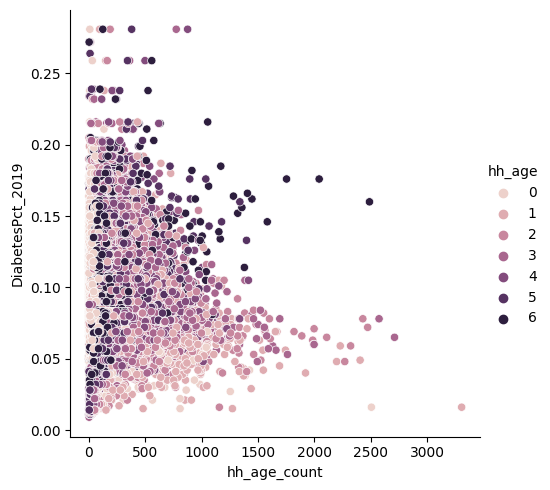

In [7]:
house_data_age_agg_diab = house_data_age_agg.copy()
house_data_age_agg_diab.rename(columns = {'tract_fips':'geo'},inplace=True)
house_data_age_agg_diab =  pd.merge(rti_rarity_data,house_data_age_agg_diab,how='left',on='geo')
sns.relplot(data=house_data_age_agg_diab, x="hh_age_count", y="DiabetesPct_2019", hue="hh_age",)
del house_data_age_agg_diab

In the above plot, plotted the average house hold age count of FIPS against diabetes prevelance rate in the FIPS and seeing lower the age categoris with higher count of average house hold age where we can see less diabetes prevalence rate, so the hh_age_count is one of the significant predictor for the diabetes prevelance rate in the county.

hh_age (age of the head of household)
• 0: <25
• 1: 25-34
• 2: 35-44
• 3: 45-54
• 4: 55-64
• 5: 65-74
• 6: >=75

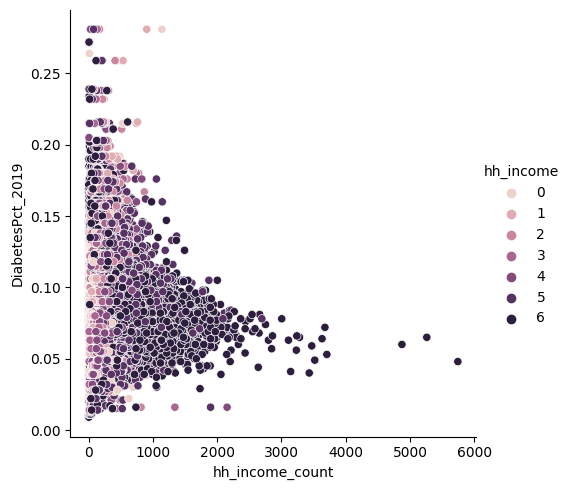

In [8]:
house_data_inc_agg_diab = house_data_inc_agg.copy()
house_data_inc_agg_diab.rename(columns = {'tract_fips':'geo'},inplace=True)
house_data_inc_agg_diab =  pd.merge(rti_rarity_data,house_data_inc_agg_diab,how='left',on='geo')
sns.relplot(data=house_data_inc_agg_diab, x="hh_income_count", y="DiabetesPct_2019", hue="hh_income",)
del house_data_inc_agg_diab

In the above plot, plotted the average house hold income count of FIPS against diabetes prevelance rate in the FIPS and seeing higher the income categories with higher count of average house hold income where we can see less diabetes prevalence rate, so the hh_income_count is one of the significant predictor for the diabetes prevelance rate in the county.

hh_income (12-month income of the household)
• 0: <10k
• 1: 10k-15k
• 2: 15k-25k
• 3: 25k-35k
• 4: 35k-50k
• 5: 50k-100k
• 6: >100k

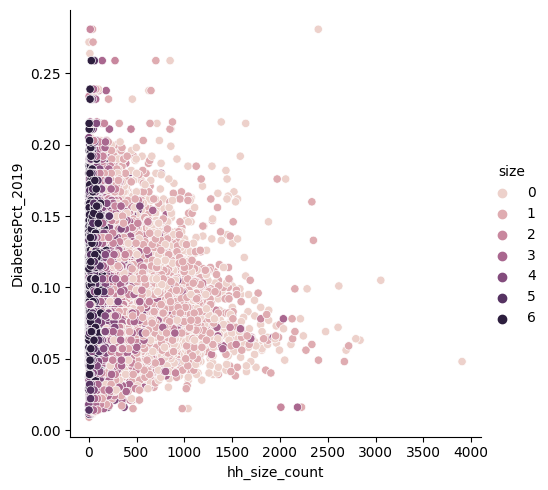

In [9]:
house_data_siz_agg_diab = house_data_siz_agg.copy()
house_data_siz_agg_diab.rename(columns = {'tract_fips':'geo'},inplace=True)
house_data_siz_agg_diab =  pd.merge(rti_rarity_data,house_data_siz_agg_diab,how='left',on='geo')
sns.relplot(data=house_data_siz_agg_diab, x="hh_size_count", y="DiabetesPct_2019", hue="size",)
del house_data_siz_agg_diab

In the above plot, plotted the average house hold size count of FIPS against diabetes prevelance rate in the FIPS and seeing lower the house hold size categories with higher count of average house hold size where we can see less diabetes prevalence rate, so the hh_size_count is one of the significant predictor for the diabetes prevelance rate in the county.

size (number of people in the household)
• 0: 1 
• 1: 2
• 2: 3 
• 3: 4
• 4: 5
• 5: 6
• 6: 7+

In [10]:
house_data_age_agg_pvt = house_data_age_agg.pivot(index='tract_fips', columns='hh_age', values='hh_age_count').reset_index().add_prefix('age_')
house_data_inc_agg_pvt = house_data_inc_agg.pivot(index='tract_fips', columns='hh_income', values='hh_income_count').reset_index().add_prefix('income_')
house_data_rac_agg_pvt = house_data_rac_agg.pivot(index='tract_fips', columns='hh_race', values='hh_race_count').reset_index().add_prefix('race_')
house_data_siz_agg_pvt = house_data_siz_agg.pivot(index='tract_fips', columns='size', values='hh_size_count').reset_index().add_prefix('size_')
house_data_age_agg_pvt.rename(columns = {'age_tract_fips':'geo'},inplace=True)
house_data_inc_agg_pvt.rename(columns = {'income_tract_fips':'geo'},inplace=True)
house_data_rac_agg_pvt.rename(columns = {'race_tract_fips':'geo'},inplace=True)
house_data_siz_agg_pvt.rename(columns = {'size_tract_fips':'geo'},inplace=True)
house_data_age_agg_pvt.head()

hh_age         geo  age_0.0  age_1.0  age_2.0  age_3.0  age_4.0  age_5.0  \
0       6001400100      NaN     50.0    192.0    188.0    356.0    254.0   
1       6001400200     12.0    166.0    125.0    195.0    105.0    174.0   
2       6001400300     39.0    465.0    496.0    541.0    360.0    333.0   
3       6001400400      NaN    580.0    385.0    258.0    255.0    213.0   
4       6001400500     74.0    446.0    385.0    304.0    188.0    127.0   

hh_age  age_6.0  
0         217.0  
1          69.0  
2         221.0  
3          91.0  
4          94.0

The house hold age,income,siz count of each FIPS are converted to percentage for feeding in to the model.

In [11]:
house_data_age_agg_pvt = pd.concat([house_data_age_agg_pvt['geo'],house_data_age_agg_pvt[['age_0.0','age_1.0','age_2.0','age_3.0','age_4.0','age_5.0','age_6.0']].div(house_data_age_agg_pvt[['age_0.0','age_1.0','age_2.0','age_3.0','age_4.0','age_5.0','age_6.0']].sum(axis=1), axis=0)],axis=1)
house_data_inc_agg_pvt = pd.concat([house_data_inc_agg_pvt['geo'],house_data_inc_agg_pvt[['income_0.0','income_1.0','income_2.0','income_3.0','income_4.0','income_5.0','income_6.0']].div(house_data_inc_agg_pvt[['income_0.0','income_1.0','income_2.0','income_3.0','income_4.0','income_5.0','income_6.0']].sum(axis=1), axis=0)],axis=1)
house_data_rac_agg_pvt = pd.concat([house_data_rac_agg_pvt['geo'],house_data_rac_agg_pvt[['race_0.0','race_1.0','race_2.0','race_3.0','race_4.0']].div(house_data_rac_agg_pvt[['race_0.0','race_1.0','race_2.0','race_3.0','race_4.0']].sum(axis=1), axis=0)],axis=1)
house_data_siz_agg_pvt = pd.concat([house_data_siz_agg_pvt['geo'],house_data_siz_agg_pvt[['size_0.0','size_1.0','size_2.0','size_3.0','size_4.0','size_5.0','size_6.0']].div(house_data_rac_agg_pvt[['race_0.0','race_1.0','race_2.0','race_3.0','race_4.0']].sum(axis=1), axis=0)],axis=1)
house_data_age_agg_pvt.head()

geo   age_0.0   age_1.0   age_2.0   age_3.0   age_4.0   age_5.0  \
0  6001400100       NaN  0.039777  0.152745  0.149562  0.283214  0.202068   
1  6001400200  0.014184  0.196217  0.147754  0.230496  0.124113  0.205674   
2  6001400300  0.015886  0.189409  0.202037  0.220367  0.146640  0.135642   
3  6001400400       NaN  0.325477  0.216049  0.144781  0.143098  0.119529   
4  6001400500  0.045735  0.275649  0.237948  0.187886  0.116193  0.078492   

    age_6.0  
0  0.172633  
1  0.081560  
2  0.090020  
3  0.051066  
4  0.058096

# Merging House hold data from synthetic population with RTI data on tract fips

In [12]:
rti_rarity_data = pd.merge(rti_rarity_data,house_data_age_agg_pvt,how="left",on="geo")
rti_rarity_data = pd.merge(rti_rarity_data,house_data_inc_agg_pvt,how="left",on="geo")
rti_rarity_data = pd.merge(rti_rarity_data,house_data_siz_agg_pvt,how="left",on="geo")

In [13]:
del house_data_age_agg_pvt,house_data_inc_agg_pvt,house_data_rac_agg_pvt,house_data_siz_agg_pvt,house_data_age_agg,house_data_inc_agg,house_data_rac_agg,house_data_siz_agg
gc.collect()

660

# Loading the person level data from CASynthetic population data

    The person level data is huge data with 35 million records on person lvel, so perform the EDA , gather required data points on tract fips level with aggregate and delete the person data to reduce memory.

In [14]:
person = pd.read_csv('SynthPop_CA/CA2017_Persons.csv',usecols = ['hh_id','rac1p'])
house_data = pd.read_csv('SynthPop_CA/CA2017_Households.csv',usecols = ['hh_id','tract_fips'])
person.head()

hh_id  rac1p
0  6_16409.0      1
1  6_52044.0      1
2  6_53384.0      1
3  6_53385.0      1
4  6_56079.0      1

Let's find any columns that have info about `diabetes` or `asthma`

In [15]:
person_house = pd.merge(person,house_data,how="inner",on=['hh_id'])
print(person_house.shape,person.shape,house_data.shape)

(35656736, 3) (35656736, 2) (12884030, 2)


In [16]:
house_person_data_race_agg = person_house[['tract_fips','rac1p']].groupby(['tract_fips','rac1p']).size().reset_index()
house_person_data_race_agg.columns = ['tract_fips','rac1p','rac1p_count']
del person_house
house_person_data_race_agg.head()

tract_fips  rac1p  rac1p_count
0  6001400100      1         2176
1  6001400100      2           94
2  6001400100      3            5
3  6001400100      5            3
4  6001400100      6          437

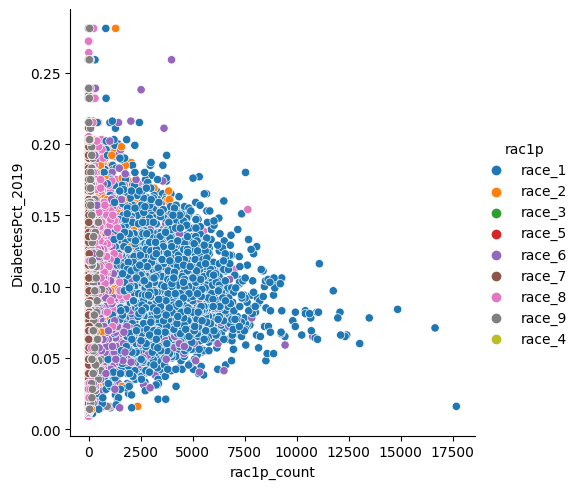

In [17]:
house_person_data_race_agg_diab = house_person_data_race_agg.copy()
house_person_data_race_agg_diab['rac1p'] = 'race_' + house_person_data_race_agg_diab['rac1p'].astype(str)
house_person_data_race_agg_diab.rename(columns = {'tract_fips':'geo'},inplace=True)
house_person_data_race_agg_diab =  pd.merge(rti_rarity_data[['geo','DiabetesPct_2019']],house_person_data_race_agg_diab,how='left',on='geo')
sns.relplot(data=house_person_data_race_agg_diab, x="rac1p_count", y="DiabetesPct_2019", hue="rac1p",)
del house_person_data_race_agg_diab

rac1p (race of person)
• 1 .White alone 
• 2 .Black or African American alone 
• 3 .American Indian alone 
• 4 .Alaska Native alone 
• 5 .American Indian and Alaska Native tribes specified; or .American Indian or Alaska Native, 
not specified and no other .races 
• 6 .Asian alone 
• 7 .Native Hawaiian and Other Pacific Islander alone 
• 8 .Some Other Race alone 
• 9 .Two or More Races

In [18]:
house_person_data_race_agg_pvt = house_person_data_race_agg.pivot(index='tract_fips', columns='rac1p', values='rac1p_count').reset_index().add_prefix('race_')
house_person_data_race_agg_pvt.rename(columns = {'race_tract_fips':'geo'},inplace=True)
house_person_data_race_agg_pvt.head()

rac1p         geo  race_1  race_2  race_3  race_4  race_5  race_6  race_7  \
0      6001400100  2176.0    94.0     5.0     NaN     3.0   437.0     6.0   
1      6001400200  1514.0    41.0     3.0     NaN     1.0   206.0     1.0   
2      6001400300  3372.0   527.0    15.0     NaN     8.0   576.0     5.0   
3      6001400400  2550.0   244.0    17.0     NaN     5.0   597.0    10.0   
4      6001400500  2124.0   870.0    11.0     NaN     5.0   241.0     2.0   

rac1p  race_8  race_9  
0        30.0   165.0  
1        27.0   136.0  
2        98.0   271.0  
3       104.0   266.0  
4       105.0   299.0

In [19]:
house_person_data_race_agg_pvt = pd.concat([house_person_data_race_agg_pvt['geo'],house_person_data_race_agg_pvt[['race_1','race_2','race_3','race_4','race_5','race_6','race_7','race_8','race_9']].div(house_person_data_race_agg_pvt[['race_1','race_2','race_3','race_4','race_5','race_6','race_7','race_8','race_9']].sum(axis=1), axis=0)],axis=1)
house_person_data_race_agg_pvt.head()

geo    race_1    race_2    race_3  race_4    race_5    race_6  \
0  6001400100  0.746228  0.032236  0.001715     NaN  0.001029  0.149863   
1  6001400200  0.784863  0.021255  0.001555     NaN  0.000518  0.106791   
2  6001400300  0.692118  0.108169  0.003079     NaN  0.001642  0.118227   
3  6001400400  0.672291  0.064329  0.004482     NaN  0.001318  0.157395   
4  6001400500  0.580804  0.237900  0.003008     NaN  0.001367  0.065901   

     race_7    race_8    race_9  
0  0.002058  0.010288  0.056584  
1  0.000518  0.013997  0.070503  
2  0.001026  0.020115  0.055624  
3  0.002636  0.027419  0.070129  
4  0.000547  0.028712  0.081761

In [20]:
rti_rarity_data = pd.merge(rti_rarity_data,house_person_data_race_agg_pvt,how="left",on="geo")

# Diabetes column from the RTI wide format data and choosing the year 2019 for analysis

In [21]:
[(i,col) for (i, col) in enumerate(rti_rarity_data.columns) if 'diabetes' in col.lower() ]

[(3346, 'DiabetesPct_2000'),
 (3347, 'DiabetesPct_2008'),
 (3348, 'DiabetesPct_2009'),
 (3349, 'DiabetesPct_2010'),
 (3350, 'DiabetesPct_2011'),
 (3351, 'DiabetesPct_2012'),
 (3352, 'DiabetesPct_2013'),
 (3353, 'DiabetesPct_2014'),
 (3354, 'DiabetesPct_2015'),
 (3355, 'DiabetesPct_2016'),
 (3356, 'DiabetesPct_2017'),
 (3357, 'DiabetesPct_2018'),
 (3358, 'DiabetesPct_2019'),
 (3359, 'DiabetesPct_2020'),
 (3360, 'DiabetesPct_2021'),
 (3361, 'DiabetesPct_2001'),
 (3362, 'DiabetesPct_2002'),
 (3363, 'DiabetesPct_2003'),
 (3364, 'DiabetesPct_2004'),
 (3365, 'DiabetesPct_2005'),
 (3366, 'DiabetesPct_2006'),
 (3367, 'DiabetesPct_2007')]

In [22]:
rti_rarity_data[[ 'geo', 'DiabetesPct_2019']]

geo  DiabetesPct_2019
0      6001400100             0.080
1      6001400200             0.062
2      6001400300             0.059
3      6001400400             0.058
4      6001400500             0.070
...           ...               ...
10300  6115040702               NaN
10301  6115041001               NaN
10302  6115041002               NaN
10303  6115041101               NaN
10304  6115041102               NaN

[10305 rows x 2 columns]

# Histogram plot for the Diabetes prevelance rate in 2019

<AxesSubplot:xlabel='DiabetesPct_2019', ylabel='Count'>

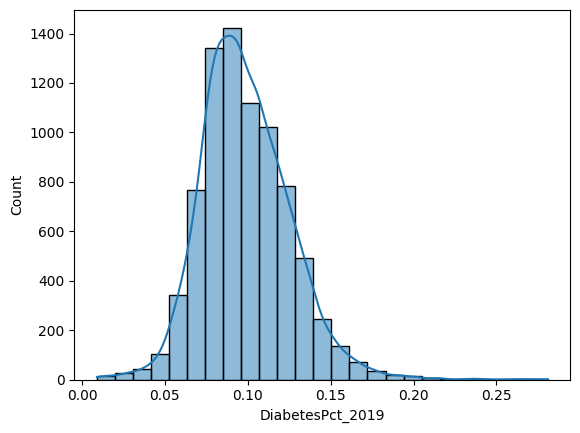

In [23]:
sns.histplot(x= "DiabetesPct_2019",
             data=rti_rarity_data,
              bins=25,
              kde=True
              )

In [24]:
print('mean:'+str(np.mean(rti_rarity_data['DiabetesPct_2019'])))
print('median:'+str(np.nanmedian(rti_rarity_data['DiabetesPct_2019'])))
print('Standard deviation:'+str(np.std(rti_rarity_data['DiabetesPct_2019'])))

mean:0.09878335832083958
median:0.096
Standard deviation:0.02680101482627445


# Selecting only the 2019 columns from the wide format data

In [25]:
col_sel = [(col) for (i, col) in enumerate(rti_rarity_data.columns) if '2019' in col or '_20' not in col ]
col_sel_new = [(col) for (i, col) in enumerate(rti_rarity_data.columns) if '_20' not in col]
rti_rarity_data_sel = rti_rarity_data[col_sel]
print(rti_rarity_data_sel.shape)
rti_rarity_data_sel.head()

(10305, 215)


geo_type         geo  ChildOpptyIndx_2019  ChildOpptyIndxEdu_2019  \
0    tract  6001400100                  NaN                     NaN   
1    tract  6001400200                  NaN                     NaN   
2    tract  6001400300                  NaN                     NaN   
3    tract  6001400400                  NaN                     NaN   
4    tract  6001400500                  NaN                     NaN   

   PublicAsstPct_2019  LargeMortPct_2019  LargeRentPct_2019  \
0            0.000000           0.336522           0.300699   
1            0.000000           0.201905           0.192547   
2            0.018025           0.187377           0.351787   
3            0.056604           0.235772           0.316729   
4            0.033001           0.277429           0.379132   

   NoComputerPct_2019  MedianIncome_2019  EducatedPoorPct_2019  ...  size_6.0  \
0                 NaN            93542.0              0.011547  ...      13.0   
1                 NaN            91705.0              0.000000  ...       3.0   
2                 NaN            69103.0              0.000000  ...       NaN   
3                 NaN            64328.0              0.006443  ...       NaN   
4                 NaN            48750.0              0.024112  ...      16.0   

     race_1    race_2    race_3  race_4    race_5    race_6    race_7  \
0  0.746228  0.032236  0.001715     NaN  0.001029  0.149863  0.002058   
1  0.784863  0.021255  0.001555     NaN  0.000518  0.106791  0.000518   
2  0.692118  0.108169  0.003079     NaN  0.001642  0.118227  0.001026   
3  0.672291  0.064329  0.004482     NaN  0.001318  0.157395  0.002636   
4  0.580804  0.237900  0.003008     NaN  0.001367  0.065901  0.000547   

     race_8    race_9  
0  0.010288  0.056584  
1  0.013997  0.070503  
2  0.020115  0.055624  
3  0.027419  0.070129  
4  0.028712  0.081761  

[5 rows x 215 columns]

# Eliminating the records with diabetes prevalance rate 2019 is not captured.

In [26]:

rti_rarity_data_sel = rti_rarity_data_sel[~rti_rarity_data_sel['DiabetesPct_2019'].isnull()]
print(rti_rarity_data_sel.shape)


(8004, 215)


# Joining the RTI with CASynthpop data and SDOH data for further analysis

In [27]:
rti_rarity_data_sel = pd.merge(rti_rarity_data_sel,cali_sample,how="left",left_on='geo', right_on='TRACTFIPS')

# Missing Data Analysis
     To find the columns with most missing data and eliminated the columns with 95 % missing data

In [28]:
plt.figure(figsize=(18.5,12.5))
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
data_missing= missing_values_table(rti_rarity_data_sel)
data_missing    

Your selected dataframe has 544 columns.
There are 511 columns that have missing values.


Missing Values  % of Total Values
ChildOpptyIndx_2019                  8004              100.0
TractLatitude_2019                   8004              100.0
MentHlthProvPer1k_2019               8004              100.0
PreventableHospPer1k_2019            8004              100.0
TeenBirthsPer1K_2019                 8004              100.0
...                                   ...                ...
NHBlackPct_2019                         2                0.0
NHAIANPct_2019                          2                0.0
NHWhitePct_2019                         2                0.0
NHOtherPct_2019                         2                0.0
UnemployedPct_2019                      2                0.0

[511 rows x 2 columns]

<Figure size 1850x1250 with 0 Axes>

In [29]:
print(data_missing['% of Total Values'].value_counts())
data_missing_pct = data_missing[data_missing['% of Total Values'] > 95].index.tolist()
data_missing.to_csv('data_missing.csv')
data_missing_pct

14.7     118
100.0     99
15.0      72
14.9      64
0.3       14
        ... 
16.8       1
16.6       1
99.4       1
72.5       1
16.5       1
Name: % of Total Values, Length: 63, dtype: int64


['ChildOpptyIndx_2019',
 'TractLatitude_2019',
 'MentHlthProvPer1k_2019',
 'PreventableHospPer1k_2019',
 'TeenBirthsPer1K_2019',
 'BusinessesN_2019',
 'MammogramPct_2019',
 'ShortSleepPct_2019',
 'ToothLossPct_2019',
 'SDI_2019',
 'SVI_2019',
 'TwoParentsOpptyPct_2019',
 'FQHCPer100k_2019',
 'LowBirthweightPct_2019',
 'AnnualAvgPM25_2019',
 'StudentsSubsLunchPct_2019',
 'StudentsELLPct_2019',
 'StudentsSpecEdPct_2019',
 'StudentsEconDisPct_2019',
 'SNAPPct_2019',
 'Section8HousePct_2019',
 'PresVotersPct_2019',
 'ChildOpptyIndxEdu_2019',
 'LimitedEnglishPct_2019',
 'EvictionPct_2019',
 'PretermBirthPct_2019',
 'SameSexPartnersPct_2019',
 'TrumpVotersPct_2019',
 'HSGrad4YrPct_2019',
 'LowSocialSupportPct_2019',
 'ReligiousAdherPer1k_2019',
 'NonprofitsAndCongregationsPer1k_2019',
 'HospReadmitsPct_2019',
 'FFSBenesN_2019',
 'FQHCRHCCost_2019',
 'EDVisitsPer1k_2019',
 'MedianAQI_2019',
 'NetMigration_2019',
 'SchoolAchieveIndx_2019',
 'HIVPrev100k_2019',
 'VoterTurnoutPct_2019',
 'McareR

<AxesSubplot:>

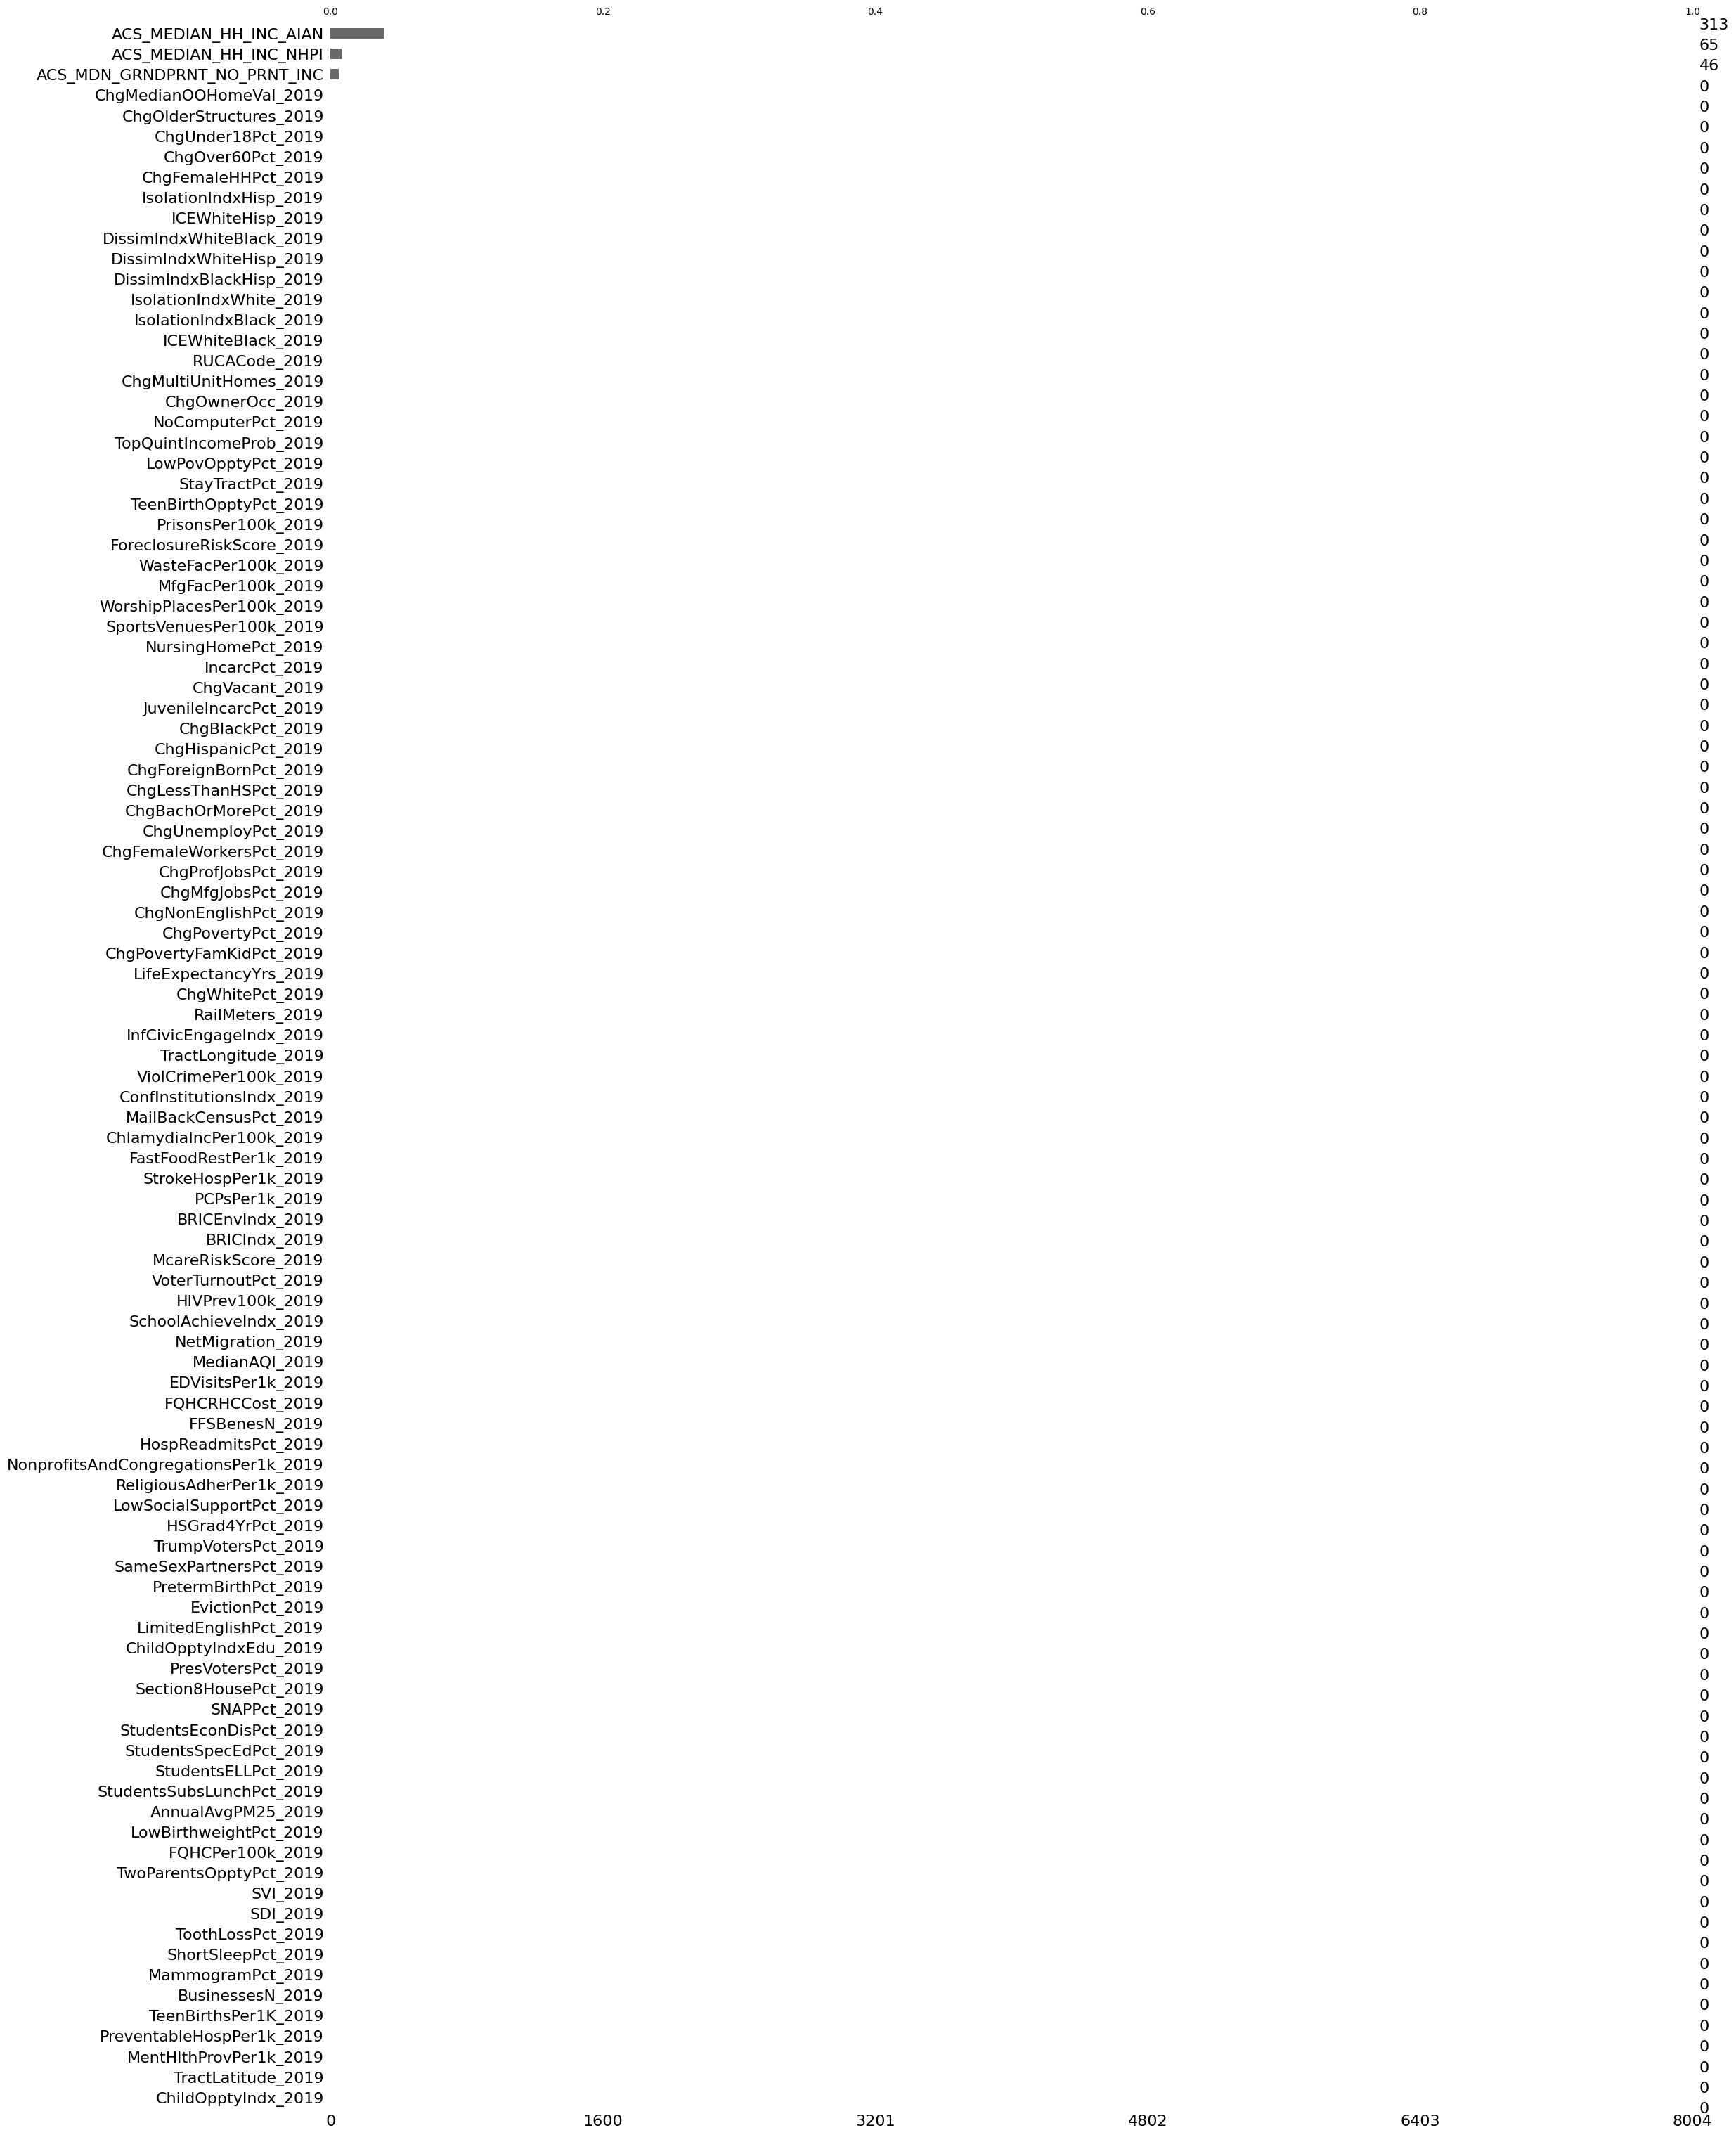

In [30]:

msno.bar(rti_rarity_data_sel[data_missing_pct])

#  Pearson Correlation Coefficient to choose features
       Choosed the feature which are has correlation more then .60 in either direction is choosed for further predictive models

In [31]:
rti_rarity_data_sel.drop(data_missing_pct,axis=1,inplace=True)
rti_rarity_data_sel_fill = rti_rarity_data_sel.fillna(-1)
print(rti_rarity_data_sel_fill.shape)
pd.set_option('display.max_columns',None)
corr_matrix = rti_rarity_data_sel_fill.corr(method="pearson")
corr_matrix1 = corr_matrix.abs()
corr_matrix1.to_csv('corr_matrix1.csv')
corr_matrix.to_csv('corr_matrix.csv')
corr_matrix1.fillna(0,inplace=True)
# Select upper triangle of correlation matrix
upper = corr_matrix1.where(np.triu(np.ones(corr_matrix1.shape), k=1).astype(np.bool))
#upper.fillna(0,inplace=True)
upper1 = corr_matrix1[(corr_matrix1.DiabetesPct_2019 > 0.60) ]
upper2_index = upper1.index.tolist()
corr_matrix1[upper2_index]




(8004, 442)


/tmp/ipykernel_492156/2591177415.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix1.where(np.triu(np.ones(corr_matrix1.shape), k=1).astype(np.bool))


MedianIncome_2019  BachOrMorePct_2019  \
geo                                 0.036195            0.005083   
PublicAsstPct_2019                  0.450998            0.499197   
LargeMortPct_2019                   0.040020            0.059458   
LargeRentPct_2019                   0.345009            0.269519   
MedianIncome_2019                   1.000000            0.836272   
...                                      ...                 ...   
POS_DIST_PED_ICU_TRACT              0.131926            0.146502   
POS_DIST_OBSTETRICS_TRACT           0.036143            0.078435   
POS_DIST_CLINIC_TRACT               0.187392            0.155150   
POS_DIST_ALC_TRACT                  0.154660            0.176310   
CEN_AIAN_NH_IND                     0.015921            0.021846   

                           LessThanHSPct_2019  MedicaidPct_2019  HTNpct_2019  \
geo                                  0.090069          0.079416     0.023185   
PublicAsstPct_2019                   0.583404          0.840000     0.213835   
LargeMortPct_2019                    0.164762          0.290746     0.088486   
LargeRentPct_2019                    0.299178          0.502283     0.100484   
MedianIncome_2019                    0.641048          0.651132     0.273102   
...                                       ...               ...          ...   
POS_DIST_PED_ICU_TRACT               0.036550          0.019122     0.230817   
POS_DIST_OBSTETRICS_TRACT            0.054319          0.066408     0.175347   
POS_DIST_CLINIC_TRACT                0.254314          0.260357     0.056422   
POS_DIST_ALC_TRACT                   0.026311          0.065160     0.225232   
CEN_AIAN_NH_IND                      0.002822          0.002711     0.093758   

                           COPDPct_2019  HeartDisPct_2019  DiabetesPct_2019  \
geo                            0.094223          0.031917          0.093215   
PublicAsstPct_2019             0.410432          0.262060          0.531884   
LargeMortPct_2019              0.036365          0.057528          0.164299   
LargeRentPct_2019              0.175592          0.113943          0.276686   
MedianIncome_2019              0.512133          0.339833          0.608436   
...                                 ...               ...               ...   
POS_DIST_PED_ICU_TRACT         0.334490          0.281896          0.069281   
POS_DIST_OBSTETRICS_TRACT      0.228676          0.187482          0.043995   
POS_DIST_CLINIC_TRACT          0.011958          0.035897          0.143582   
POS_DIST_ALC_TRACT             0.327864          0.273661          0.143353   
CEN_AIAN_NH_IND                0.062557          0.082783          0.058365   

                           BingeDrinkPct_2019  ObesityPct_2019  \
geo                                  0.201570         0.072792   
PublicAsstPct_2019                   0.285399         0.569614   
LargeMortPct_2019                    0.209828         0.086091   
LargeRentPct_2019                    0.210999         0.253836   
MedianIncome_2019                    0.206803         0.664390   
...                                       ...              ...   
POS_DIST_PED_ICU_TRACT               0.048004         0.163420   
POS_DIST_OBSTETRICS_TRACT            0.016279         0.101926   
POS_DIST_CLINIC_TRACT                0.078370         0.113516   
POS_DIST_ALC_TRACT                   0.014055         0.211828   
CEN_AIAN_NH_IND                      0.067827         0.010785   

                           PhysicallyInactivePct_2019  SmokersPct_2019  \
geo                                          0.055830         0.032765   
PublicAsstPct_2019                           0.652245         0.580612   
LargeMortPct_2019                            0.117280         0.010383   
LargeRentPct_2019                            0.340105         0.245167   
MedianIncome_2019                            0.779708         0.744658   
...                                               ...          

In [32]:

corr_matrix1_check = corr_matrix1[upper2_index]
corr_matrix1_check
corr_matrix.index
corr_matrix_sel = corr_matrix1.filter(items = upper2_index, axis=0)
corr_matrix_sel[upper2_index]


MedianIncome_2019  BachOrMorePct_2019  \
MedianIncome_2019                     1.000000            0.836272   
BachOrMorePct_2019                    0.836272            1.000000   
LessThanHSPct_2019                    0.641048            0.731888   
MedicaidPct_2019                      0.651132            0.687468   
HTNpct_2019                           0.273102            0.306950   
COPDPct_2019                          0.512133            0.548010   
HeartDisPct_2019                      0.339833            0.347885   
DiabetesPct_2019                      0.608436            0.671684   
BingeDrinkPct_2019                    0.206803            0.184397   
ObesityPct_2019                       0.664390            0.793047   
PhysicallyInactivePct_2019            0.779708            0.851613   
SmokersPct_2019                       0.744658            0.821169   
KidneyDisPct_2019                     0.525874            0.556391   
PhysicallyUnhealthyPct_2019           0.727495            0.801662   

                             LessThanHSPct_2019  MedicaidPct_2019  \
MedianIncome_2019                      0.641048          0.651132   
BachOrMorePct_2019                     0.731888          0.687468   
LessThanHSPct_2019                     1.000000          0.759383   
MedicaidPct_2019                       0.759383          1.000000   
HTNpct_2019                            0.120519          0.257224   
COPDPct_2019                           0.317706          0.494629   
HeartDisPct_2019                       0.198381          0.328038   
DiabetesPct_2019                       0.676475          0.685849   
BingeDrinkPct_2019                     0.282198          0.343136   
ObesityPct_2019                        0.676230          0.683881   
PhysicallyInactivePct_2019             0.891579          0.835603   
SmokersPct_2019                        0.687631          0.734149   
KidneyDisPct_2019                      0.499828          0.577133   
PhysicallyUnhealthyPct_2019            0.747984          0.781744   

                             HTNpct_2019  COPDPct_2019  HeartDisPct_2019  \
MedianIncome_2019               0.273102      0.512133          0.339833   
BachOrMorePct_2019              0.306950      0.548010          0.347885   
LessThanHSPct_2019              0.120519      0.317706          0.198381   
MedicaidPct_2019                0.257224      0.494629          0.328038   
HTNpct_2019                     1.000000      0.823692          0.932583   
COPDPct_2019                    0.823692      1.000000          0.902568   
HeartDisPct_2019                0.932583      0.902568          1.000000   
DiabetesPct_2019                0.727227      0.715552          0.739920   
BingeDrinkPct_2019              0.638860      0.397207          0.588469   
ObesityPct_2019                 0.390246      0.629087          0.418901   
PhysicallyInactivePct_2019      0.338693      0.567176          0.409234   
SmokersPct_2019                 0.336630      0.704352          0.405969   
KidneyDisPct_2019               0.865245      0.855450          0.907674   
PhysicallyUnhealthyPct_2019     0.589997      0.826016          0.676493   

                             DiabetesPct_2019  BingeDrinkPct_2019  \
MedianIncome_2019                    0.608436            0.206803   
BachOrMorePct_2019                   0.671684            0.184397   
LessThanHSPct_2019                   0.676475            0.282198   
MedicaidPct_2019                     0.685849            0.343136   
HTNpct_2019                          0.727227            0.638860   
COPDPct_2019                         0.715552            0.397207   
HeartDisPct_2019                     0.739920            0.588469   
DiabetesPct_2019                     1.000000            0.707985   
BingeDrinkPct_2019                   0.707985            1.000000   
ObesityPct_2019                      0.648425            0.153520   
PhysicallyInactivePct_2019           0.823

Text(0.5, 1.0, 'pearson correlation')

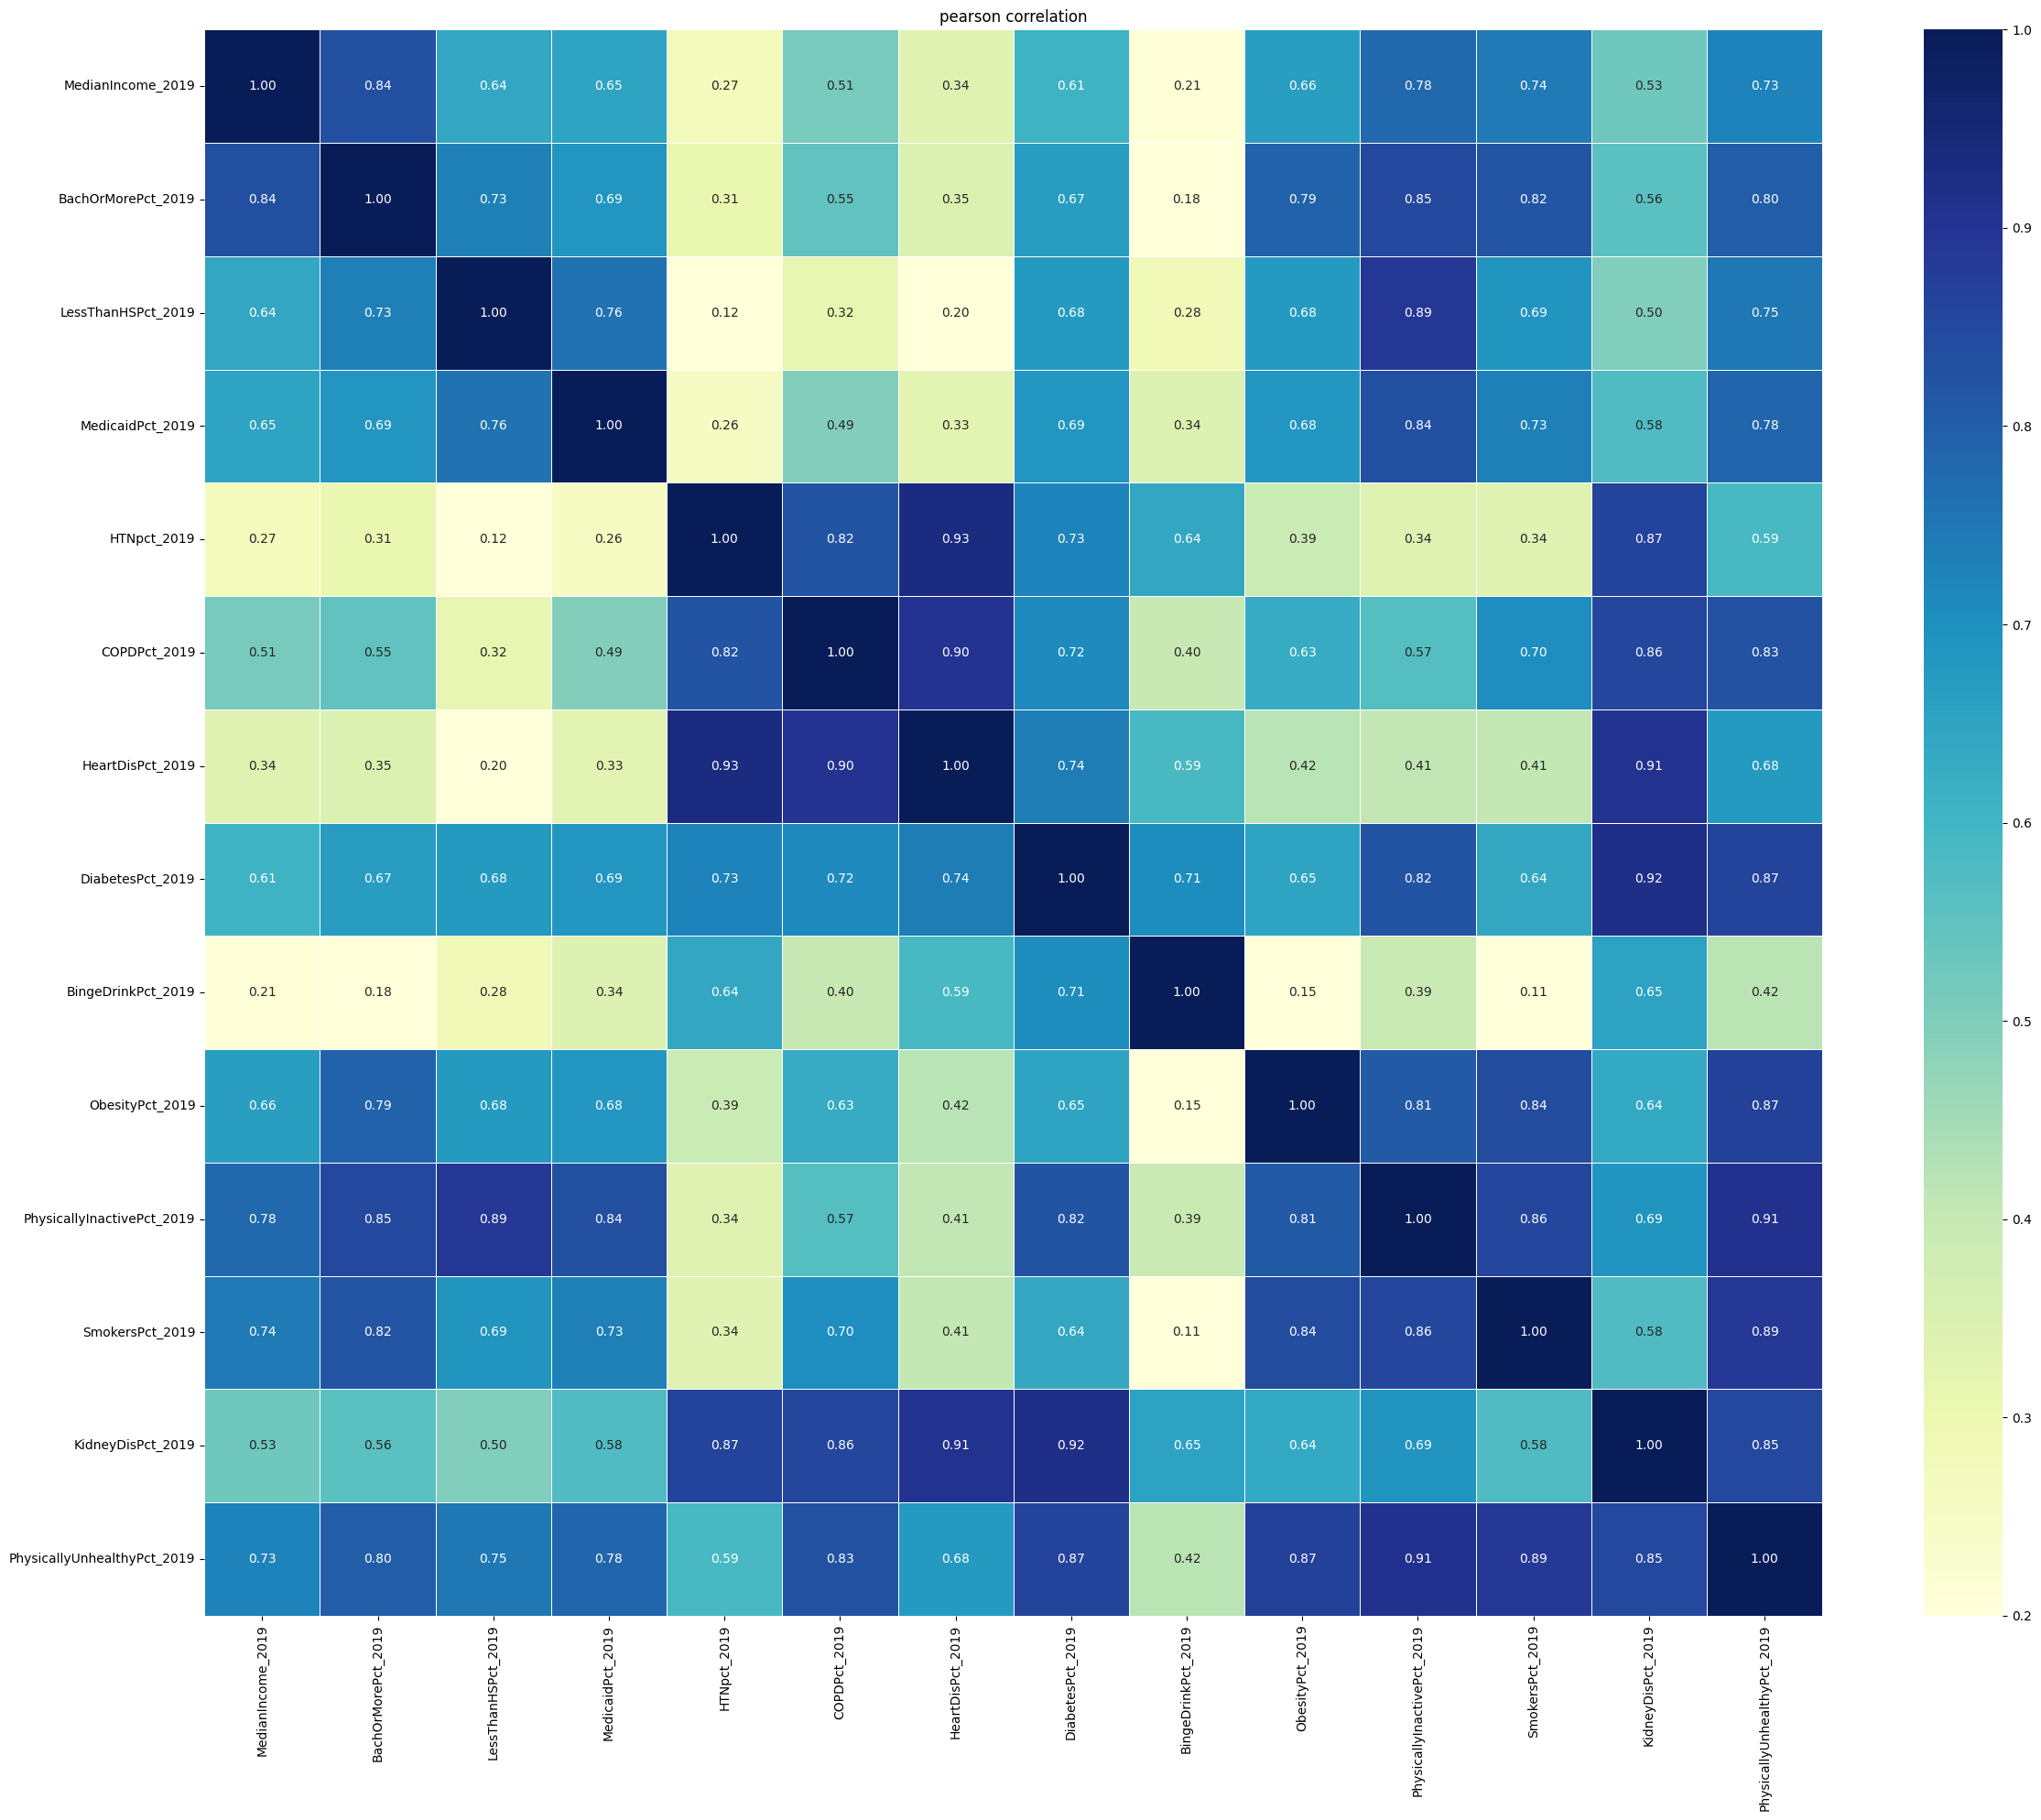

In [33]:
plt.figure(figsize=(28.5,22.5))
sns.heatmap(corr_matrix_sel[upper2_index], vmin=0.2, vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=.5)
plt.title("pearson correlation")

Pair plot of highly correlated variables with Diabetes prevelance rate. 14 feature which are highly correlated are plotted.First plotted the 7 features with diabtetes prevelance rate.And then plotted next 7 features.

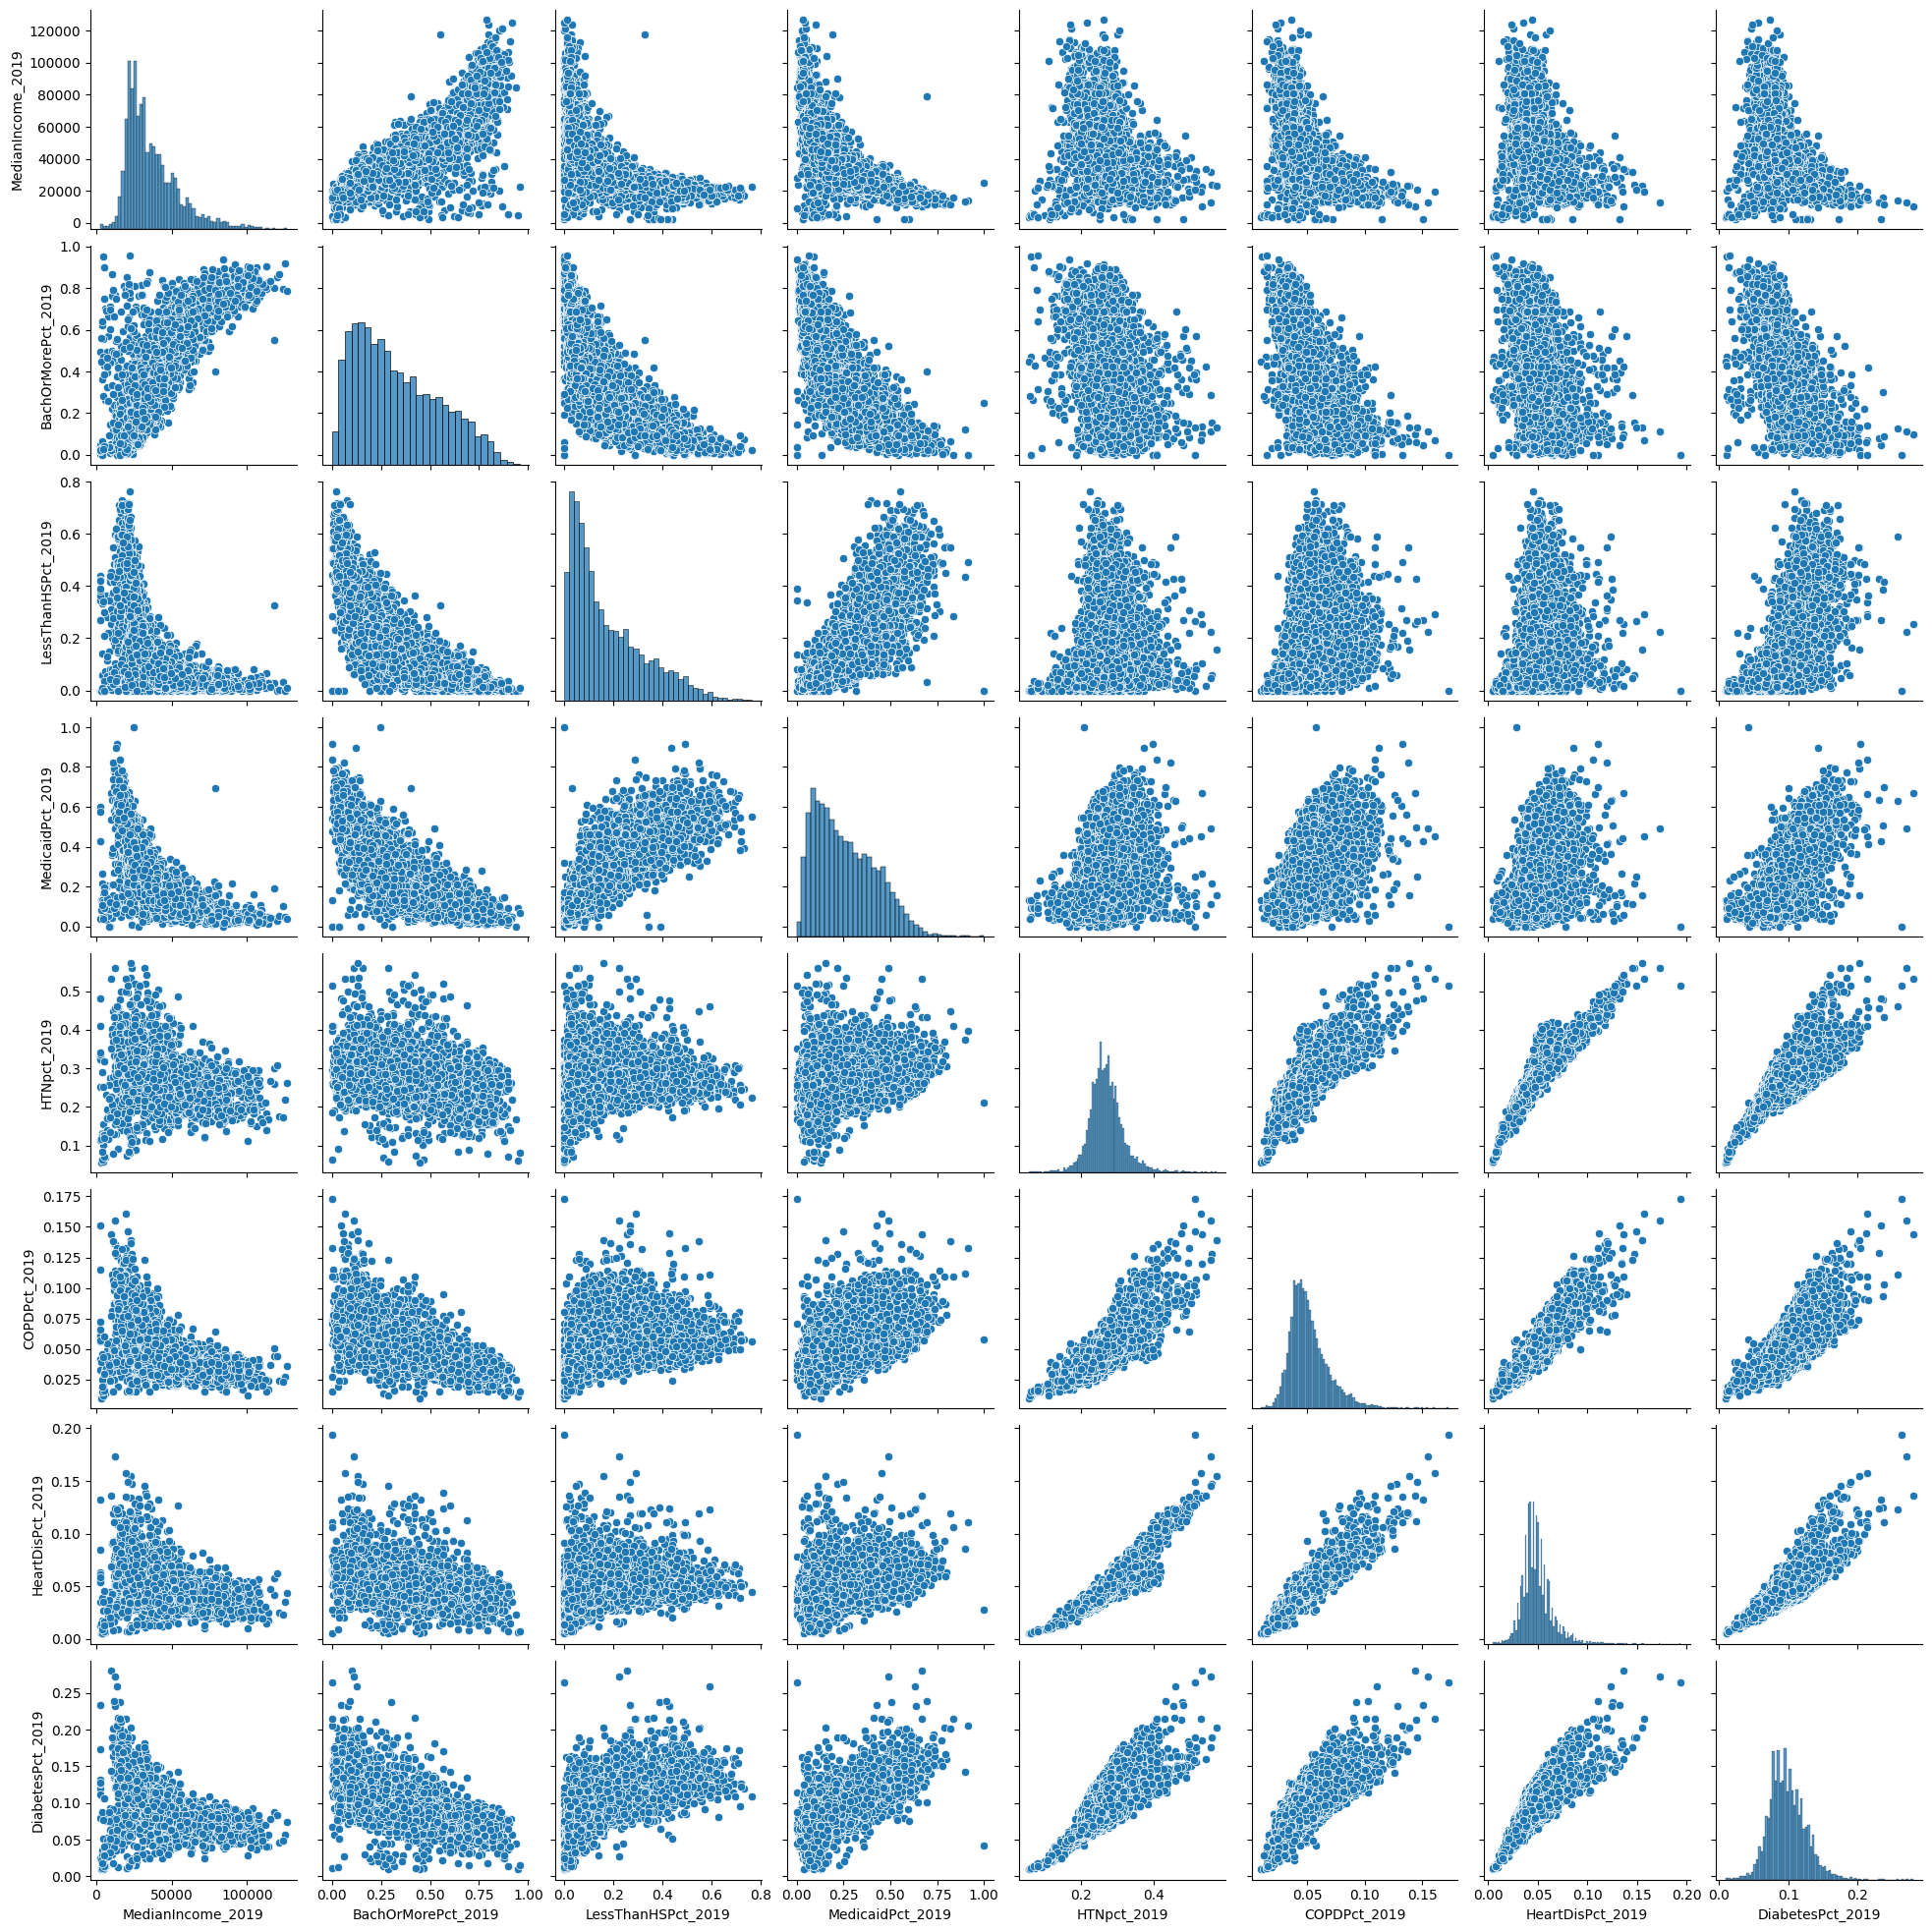

In [34]:
sns.pairplot(rti_rarity_data_sel[['MedianIncome_2019',
 'BachOrMorePct_2019',
 'LessThanHSPct_2019',
 'MedicaidPct_2019',
 'HTNpct_2019',
 'COPDPct_2019',
 'HeartDisPct_2019',
'DiabetesPct_2019']])
#upper2_index

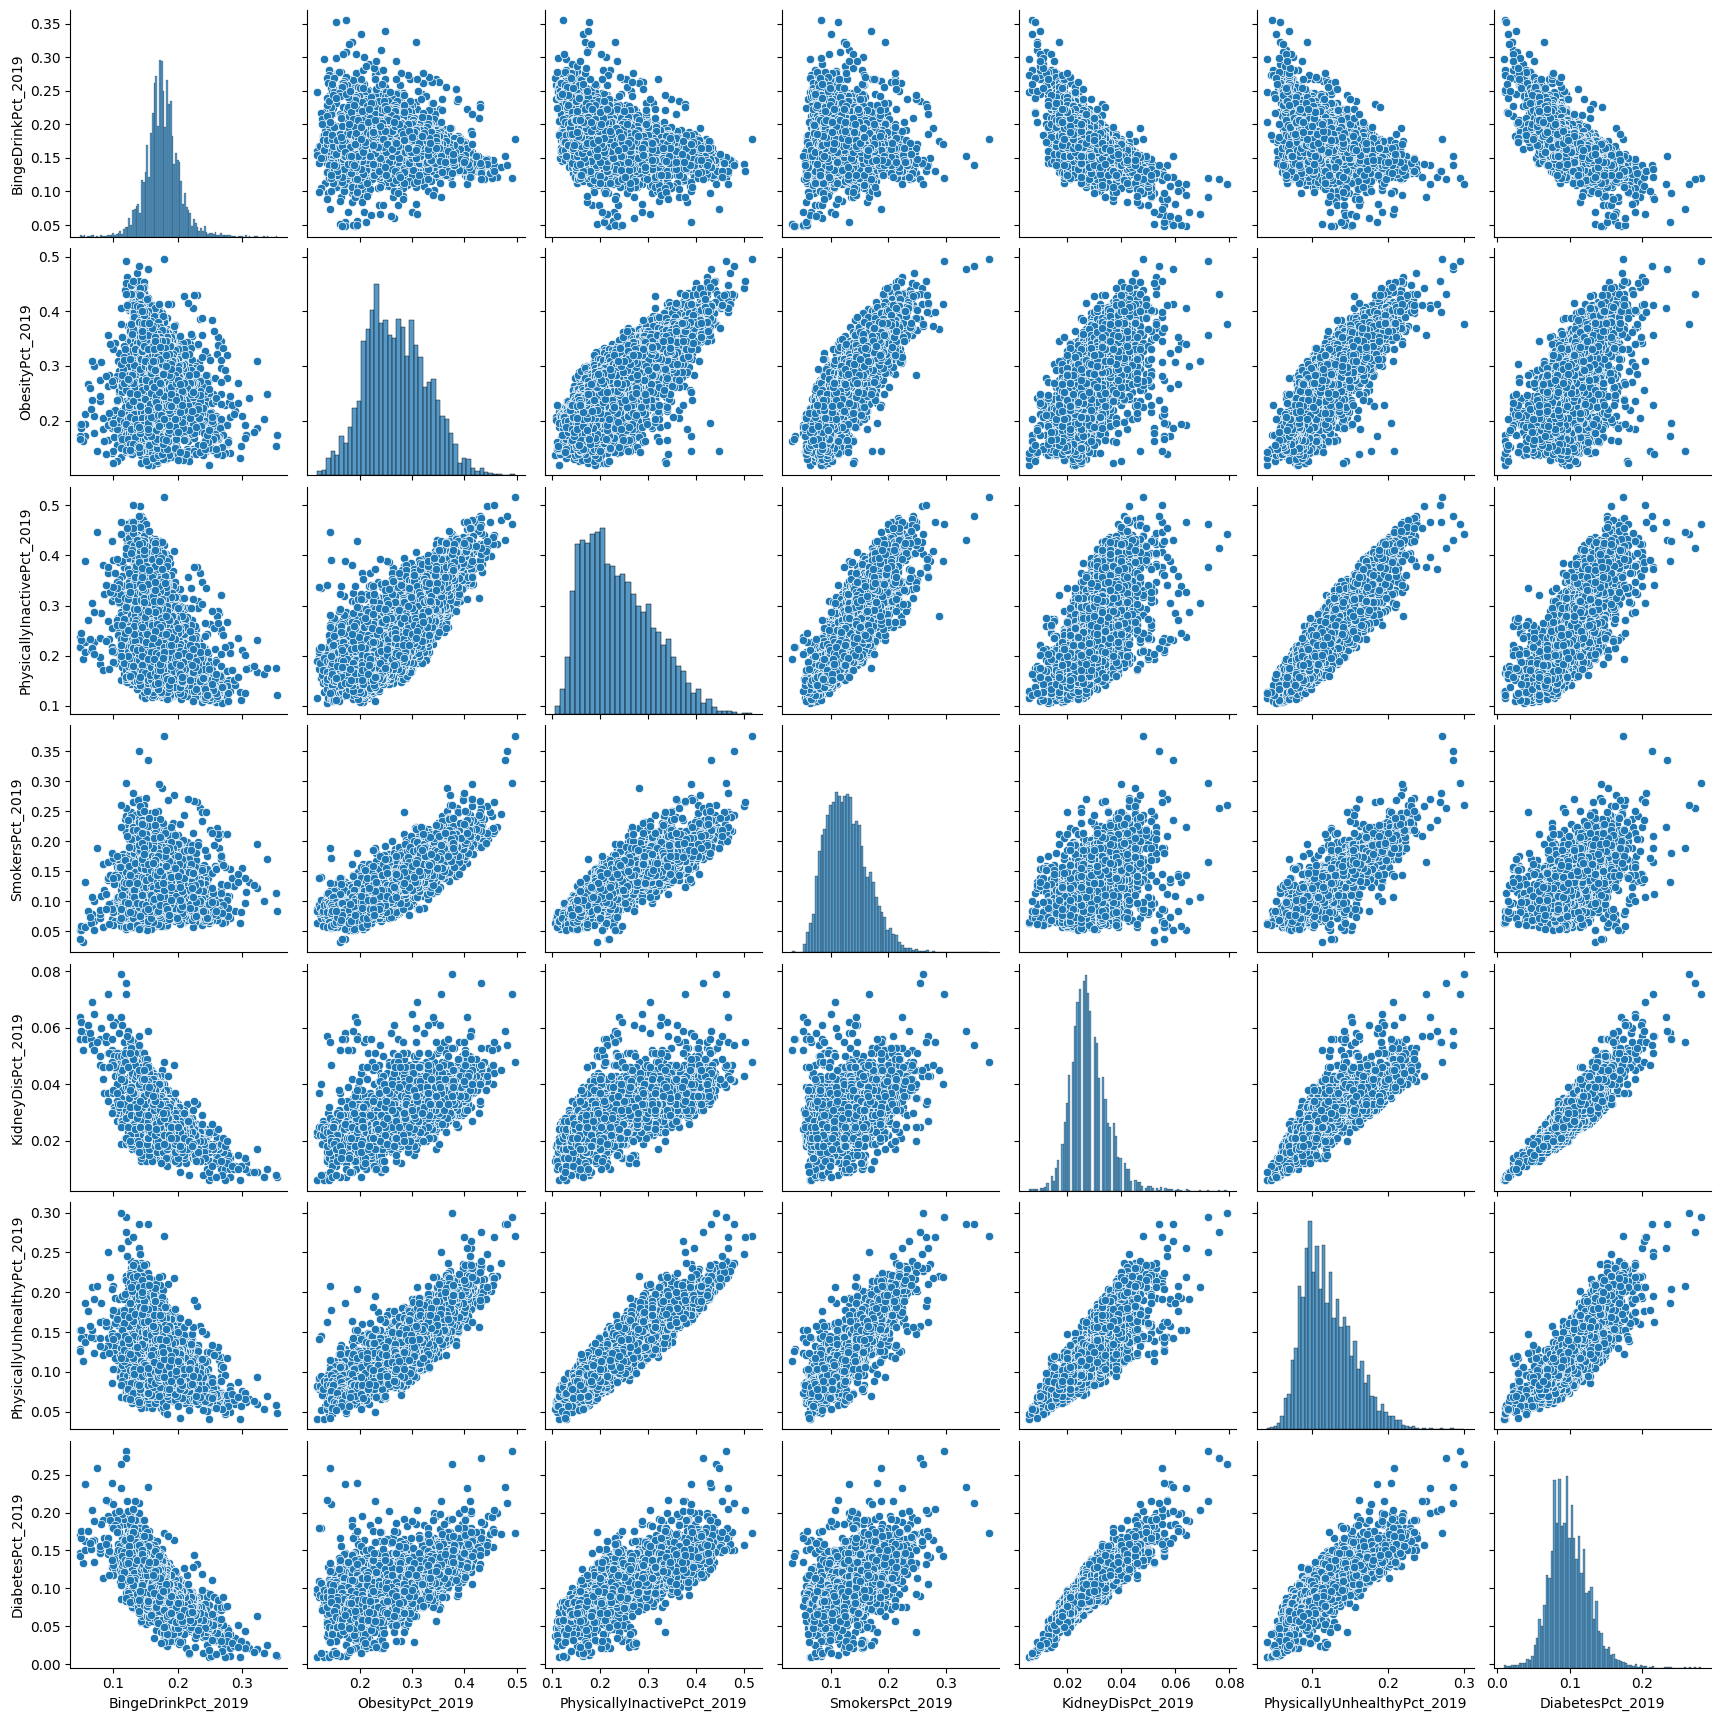

In [35]:
sns.pairplot(rti_rarity_data_sel[['BingeDrinkPct_2019',
 'ObesityPct_2019',
 'PhysicallyInactivePct_2019',
 'SmokersPct_2019',
 'KidneyDisPct_2019',
 'PhysicallyUnhealthyPct_2019',
 'DiabetesPct_2019']])

In [36]:

target = rti_rarity_data_sel['DiabetesPct_2019']
print(rti_rarity_data_sel.shape)
rti_rarity_data_sel.drop(['DiabetesPct_2019'],axis=1,inplace=True)
rti_rarity_data_sel.drop(['geo_type'],axis=1,inplace=True)
print(rti_rarity_data_sel.shape)

(8004, 442)
(8004, 440)


In [37]:

label_encoder = preprocessing.LabelEncoder()
for colname,coltype in rti_rarity_data_sel.dtypes.iteritems():
    if coltype == 'object':
        print("Encoding :","'" + colname + "'")
        rti_rarity_data_sel[colname] = label_encoder.fit_transform(rti_rarity_data_sel[colname].astype(str))        
        #colnames = train_test.groupby([colname]).size()
        #train_test[colname+"_Freq"]   = train_test[colname].apply(lambda x : colnames[x])  

Encoding : 'STATE'
Encoding : 'COUNTY'
Encoding : 'REGION'


# Cross Validation
* 95%  data for training
* 5% data for hold out validation(Never used in training)


In [38]:
train , hold_out, train_target , hold_out_target = train_test_split(rti_rarity_data_sel[['geo','MedianIncome_2019','BachOrMorePct_2019','LessThanHSPct_2019','MedicaidPct_2019','HTNpct_2019','COPDPct_2019','HeartDisPct_2019','BingeDrinkPct_2019','ObesityPct_2019','PhysicallyInactivePct_2019','SmokersPct_2019','KidneyDisPct_2019','PhysicallyUnhealthyPct_2019','COUNTY','age_0.0','age_1.0','age_2.0','age_3.0','age_4.0','age_5.0','age_6.0','income_0.0','income_1.0','income_2.0','income_3.0','income_4.0','income_5.0','income_6.0','race_1','race_2','race_3','race_4','race_5','race_6','race_7','race_8','race_9','size_0.0','size_1.0','size_2.0','size_3.0','size_4.0','size_5.0','size_6.0']], 
target, test_size=0.05, random_state=1234) 
print(rti_rarity_data_sel.shape)
print(hold_out.shape)
print(train.shape)


(8004, 440)
(401, 45)
(7603, 45)


# Model
* LightGBM
* Xgboost
* 5 fold startified cross validated model
 

In [39]:
hold_out_up = hold_out.drop('geo',axis=1)
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    #'bagging_freq': 10,
    'verbose': -1,
    'verbose_eval' :50,
    "max_depth": -1,
    "num_leaves": 20,  
    "max_bin": 400,
    "num_iterations": 100000,
    "n_estimators": 1000,
    #'lambda_l1' : 0.5,
    'random_state': 1234
}

xgb_parms = {'objective': 'reg:squarederror',           
          'booster':'gbtree',
          'metrics': 'rmse',
          'eta': 0.03,
          'max_depth': 6, 
          'subsample': 0.8, 
          'colsample_bytree': 0.8,
          #'alpha':0.1,
          'random_state': 42, 
          'silent': True}

hold_out_pred_lgbm = 0* hold_out_target
hold_out_pred_xgb = 0* hold_out_target
test_pred1 = 0
pred = 0 

#y_test_pred1 = 0* Yv
test_pred2 = 0

#y_test_pred_xgb = 0* Yv
test_pred_xgb = 0

importances_xgb = []
importances = []
models = []

oof = np.zeros(len(train))
oof_cat = np.zeros(len(train))
oof_xgb = np.zeros(len(train))
train1 = train.copy()
#rain['GDPPerCapita_2019_round'] = np.round(train['GDPPerCapita_2019'],0)

K = 5
kf = StratifiedKFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(0)
for i, (train_index, test_index) in enumerate(kf.split(train,train['COUNTY'])):
    
    # Create data for this fold
    #train1['LOCATION'] = 1
    
    y_train, y_valid = target.iloc[train_index].copy(), target.iloc[test_index]
    X_train, X_valid = train.iloc[train_index,:].copy(), train.iloc[test_index,:].copy()
    X_train.drop(['geo'],axis=1,inplace=True)
    X_valid.drop(['geo'],axis=1,inplace=True)
    #X_test = test.copy()
    print( "\nFold ", i)
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(hyper_params,lgb_train,valid_sets=[lgb_train, lgb_eval],      
        verbose_eval = 50,                      
        early_stopping_rounds=50)
    
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model_xgb = xgb.train(xgb_parms,dtrain=dtrain,evals=[(dtrain,'train'),(dvalid,'valid')],num_boost_round=9999,early_stopping_rounds=50,verbose_eval=25) 
    
    #test_pred1 +=  model.predict(X_test) 
    hold_out_pred_lgbm += model.predict(hold_out_up)
    hold_out_pred_xgb += model_xgb.predict(xgb.DMatrix(hold_out_up))
    #y_test_pred += model.predict(Xv)  
 
    models.append(model)
    
    oof_preds = model.predict(X_valid)
    oof[test_index] = oof_preds 
    
    oof_preds_xgb = model_xgb.predict(xgb.DMatrix(X_valid))
    oof_xgb[test_index] = oof_preds_xgb
    
    
    dd = model_xgb.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{K}':dd.values()})
    importances.append(df) 
#y_test_pred /= (K )  # Average test set predictions

test_pred1 /= (K )
hold_out_pred_lgbm /= (K )
hold_out_pred_xgb /= (K )


#print(math.sqrt(np.square(np.subtract((Yv),y_test_pred)).mean()))


Fold  0
[LightGBM] [Warning] Unknown parameter: verbose_eval
Training until validation scores don't improve for 50 rounds


/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback

[50]	training's rmse: 0.0247802	valid_1's rmse: 0.0277579
Early stopping, best iteration is:
[2]	training's rmse: 0.026521	valid_1's rmse: 0.0276179
[21:33:53] WARNING: ../src/learner.cc:627: 
Parameters: { "metrics", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.39043	valid-rmse:0.38938
[25]	train-rmse:0.18387	valid-rmse:0.18292
[50]	train-rmse:0.08902	valid-rmse:0.08830
[75]	train-rmse:0.04744	valid-rmse:0.04766
[100]	train-rmse:0.03121	valid-rmse:0.03295
[125]	train-rmse:0.02582	valid-rmse:0.02897
[150]	train-rmse:0.02392	valid-rmse:0.02813
[175]	train-rmse:0.02286	valid-rmse:0.02801
[200]	train-rmse:0.02216	valid-rmse:0.02798
[225]	train-rmse:0.02152	valid-rmse:0.02802
[250]	train-rmse:0.02087	valid-rmse:0.02803
[253

/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-package

[21:33:59] WARNING: ../src/learner.cc:627: 
Parameters: { "metrics", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.39004	valid-rmse:0.39101
[25]	train-rmse:0.18372	valid-rmse:0.18460
[50]	train-rmse:0.08907	valid-rmse:0.08976
[75]	train-rmse:0.04764	valid-rmse:0.04834
[100]	train-rmse:0.03151	valid-rmse:0.03262
[125]	train-rmse:0.02621	valid-rmse:0.02783
[150]	train-rmse:0.02443	valid-rmse:0.02659
[175]	train-rmse:0.02351	valid-rmse:0.02632
[200]	train-rmse:0.02280	valid-rmse:0.02625
[225]	train-rmse:0.02215	valid-rmse:0.02624
[250]	train-rmse:0.02149	valid-rmse:0.02626
[275]	train-rmse:0.02089	valid-rmse:0.02627
[276]	train-rmse:0.02087	valid-rmse:0.02626

Fold  2
[LightGBM] [Warning] Unknown parameter: verbose_eval
Tra

/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-package

[21:34:05] WARNING: ../src/learner.cc:627: 
Parameters: { "metrics", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.39029	valid-rmse:0.38999
[25]	train-rmse:0.18381	valid-rmse:0.18363
[50]	train-rmse:0.08900	valid-rmse:0.08911
[75]	train-rmse:0.04748	valid-rmse:0.04840
[100]	train-rmse:0.03131	valid-rmse:0.03349
[125]	train-rmse:0.02591	valid-rmse:0.02933
[150]	train-rmse:0.02400	valid-rmse:0.02838
[175]	train-rmse:0.02304	valid-rmse:0.02818
[200]	train-rmse:0.02228	valid-rmse:0.02815
[225]	train-rmse:0.02161	valid-rmse:0.02816
[250]	train-rmse:0.02095	valid-rmse:0.02821
[253]	train-rmse:0.02089	valid-rmse:0.02820

Fold  3
[LightGBM] [Warning] Unknown parameter: verbose_eval
Training until validation scores don't improve 

/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-package

[21:34:12] WARNING: ../src/learner.cc:627: 
Parameters: { "metrics", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.39033	valid-rmse:0.38978
[25]	train-rmse:0.18387	valid-rmse:0.18325
[50]	train-rmse:0.08913	valid-rmse:0.08839
[75]	train-rmse:0.04765	valid-rmse:0.04718
[100]	train-rmse:0.03155	valid-rmse:0.03179
[125]	train-rmse:0.02617	valid-rmse:0.02736
[150]	train-rmse:0.02427	valid-rmse:0.02635
[175]	train-rmse:0.02332	valid-rmse:0.02615
[200]	train-rmse:0.02258	valid-rmse:0.02615
[223]	train-rmse:0.02199	valid-rmse:0.02618

Fold  4
[LightGBM] [Warning] Unknown parameter: verbose_eval
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.0251153	valid_1's rmse: 0.0264078


/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/sylas/.local/share/virtualenvs/myst-uKfB42T3/lib/python3.10/site-package

[100]	training's rmse: 0.0236669	valid_1's rmse: 0.0263705
Early stopping, best iteration is:
[82]	training's rmse: 0.0241714	valid_1's rmse: 0.0263571
[21:34:17] WARNING: ../src/learner.cc:627: 
Parameters: { "metrics", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.39005	valid-rmse:0.39098
[25]	train-rmse:0.18370	valid-rmse:0.18458
[50]	train-rmse:0.08906	valid-rmse:0.08986
[75]	train-rmse:0.04759	valid-rmse:0.04848
[100]	train-rmse:0.03152	valid-rmse:0.03282
[125]	train-rmse:0.02622	valid-rmse:0.02811
[150]	train-rmse:0.02431	valid-rmse:0.02688
[175]	train-rmse:0.02331	valid-rmse:0.02658
[200]	train-rmse:0.02268	valid-rmse:0.02649
[225]	train-rmse:0.02201	valid-rmse:0.02650
[250]	train-rmse:0.02132	valid-rmse:0.02651
[

# LightGBM Faeture Importance Plot

(<Figure size 1760x700 with 1 Axes>,
 <AxesSubplot:xlabel='column', ylabel='feature_importance'>)

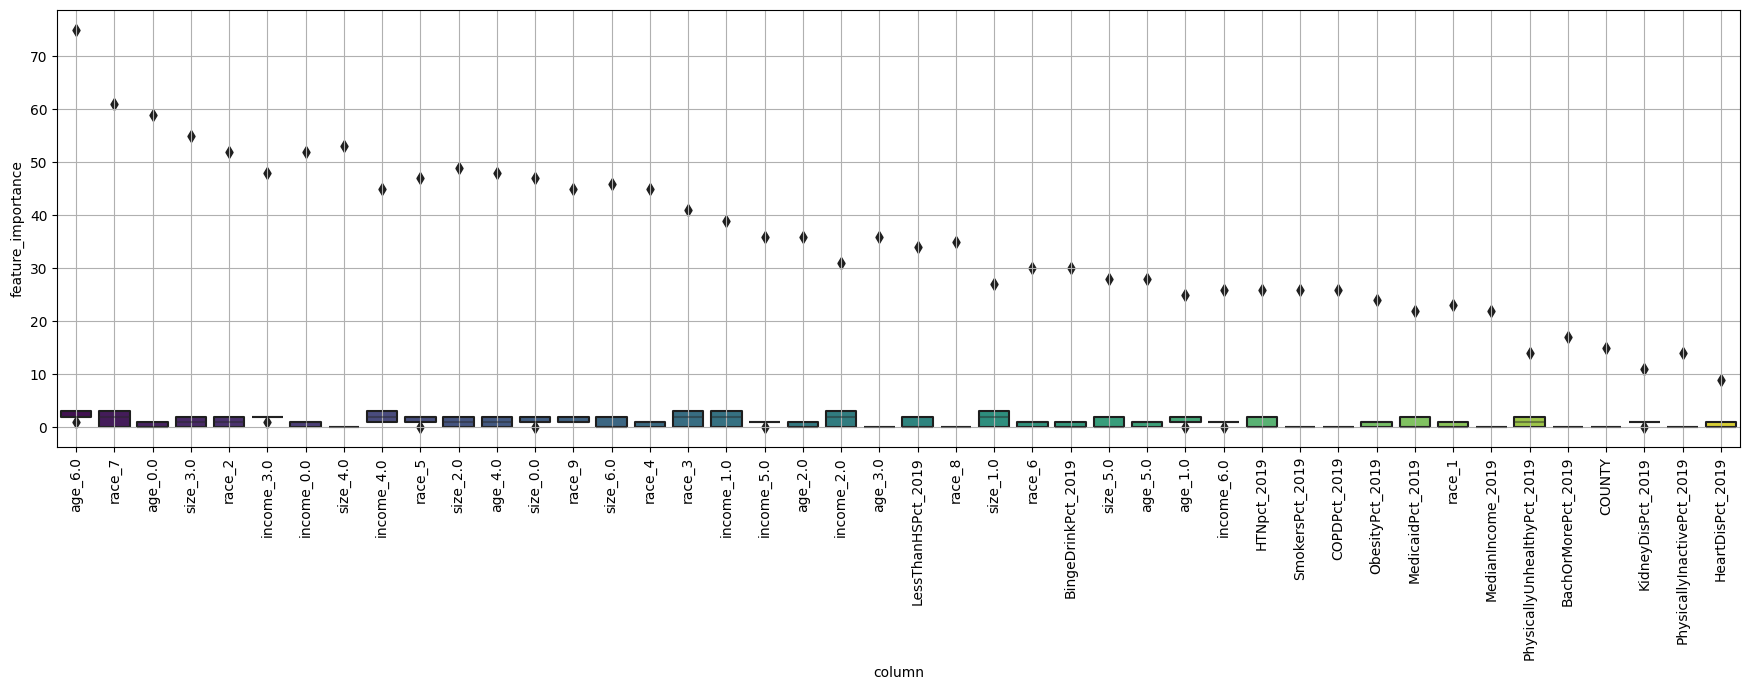

In [40]:
#Feature Importance of lightgbm model
from matplotlib import pyplot as plt
import seaborn as sns
def visualize_importance(models, X_train):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance()
        _df["column"] = X_train.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df], axis=0, ignore_index=True
        )

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )
    
    feature_importance_df.to_csv('feature_importance_lgb.csv', index=False)
    

    fig, ax = plt.subplots(figsize=(max(6, len(order) * 0.4), 7))
    sns.boxenplot(
        data=feature_importance_df,
        x="column",
        y="feature_importance",
        order=order,
        ax=ax,
        palette="viridis",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

#Feature importance visualiztion for LGBM model
visualize_importance(models, X_train)

# XGBOOST Feature Importance

/tmp/ipykernel_492156/813440246.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'importance_5_x'} in the result is deprecated and will raise a MergeError in a future version.
  for k in range(1,5): df = df.merge(importances[k], on='feature', how='left')


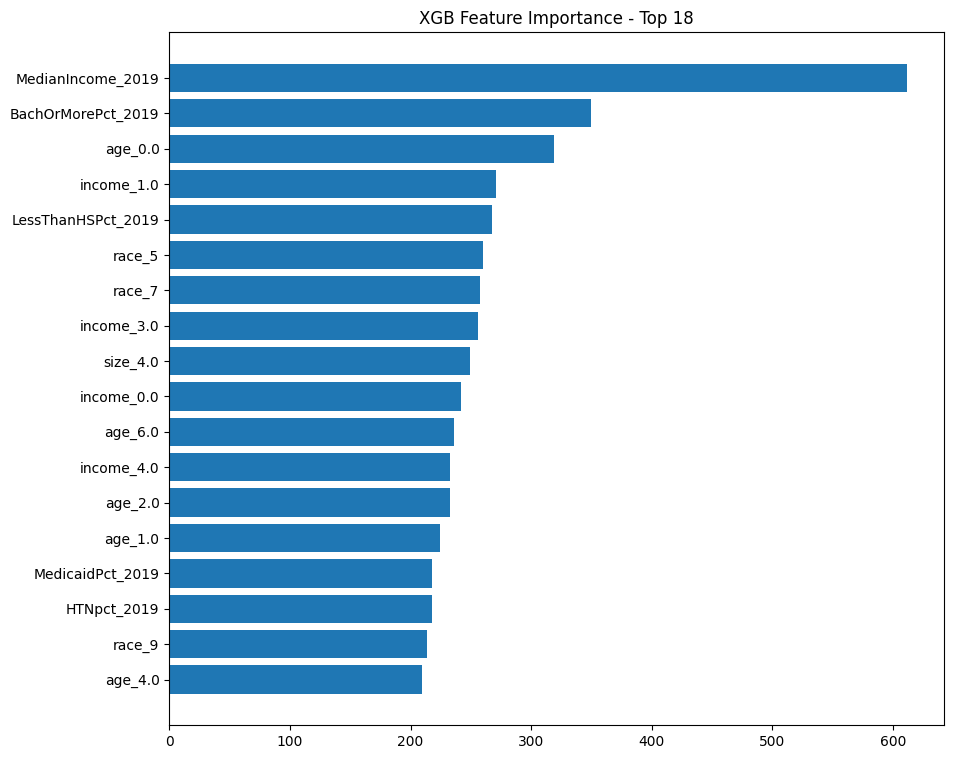

In [41]:
df = importances[0].copy()
for k in range(1,5): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v.csv',index=False)
NUM_FEATURES = 18
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

# XGBoost Feature Importance Values

In [42]:
df

feature  importance_5_x  importance_5_y  \
0             MedianIncome_2019           598.0           639.0   
1            BachOrMorePct_2019           363.0           355.0   
14                      age_0.0           291.0           350.0   
22                   income_1.0           282.0           303.0   
2            LessThanHSPct_2019           270.0           250.0   
32                       race_5           295.0           285.0   
34                       race_7           298.0           252.0   
24                   income_3.0           245.0           306.0   
41                     size_4.0           287.0           280.0   
21                   income_0.0           238.0           256.0   
20                      age_6.0           230.0           245.0   
25                   income_4.0           234.0           253.0   
16                      age_2.0           236.0           248.0   
15                      age_1.0           244.0           254.0   
3              MedicaidPct_2019           211.0           218.0   
4                   HTNpct_2019           252.0           210.0   
36                       race_9           235.0           214.0   
18                      age_4.0           232.0           213.0   
30                       race_3           204.0           211.0   
17                      age_3.0           202.0           207.0   
23                   income_2.0           212.0           181.0   
40                     size_3.0           157.0           216.0   
37                     size_0.0           209.0           196.0   
39                     size_2.0           213.0           193.0   
29                       race_2           184.0           201.0   
33                       race_6           193.0           183.0   
19                      age_5.0           177.0           191.0   
26                   income_5.0           187.0           180.0   
43                     size_6.0           185.0           222.0   
38                     size_1.0           189.0           162.0   
42                     size_5.0           184.0           198.0   
31                       race_4           172.0           175.0   
8               ObesityPct_2019           139.0           158.0   
7            BingeDrinkPct_2019           147.0           163.0   
28                       race_1           142.0           169.0   
35                       race_8           128.0           147.0   
27                   income_6.0           141.0           169.0   
10              SmokersPct_2019           110.0           127.0   
13                       COUNTY           121.0           117.0   
5                  COPDPct_2019            98.0           112.0   
9    PhysicallyInactivePct_2019            95.0           117.0   
6              HeartDisPct_2019            80.0            79.0   
12  PhysicallyUnhealthyPct_2019            61.0            49.0   
11            KidneyDisPct_2019            47.0            61.0   

    importance_5_x  importance_5_y  importance_5  importance  
0            561.0           571.0         690.0       611.8  
1            350.0           285.0         394.0       349.4  
14           309.0           272.0         371.0       318.6  
22           252.0           211.0         306.0       270.8  
2            231.0           248.0         337.0       267.2  
32           265.0           150.0         304.0       259.8  
34           227.0           246.0         265.0       257.6  
24           240.0           230.0         259.0       256.0  
41           225.0           160.0         293.0       249.0  
21           240.0           205.0         270.0       241.8  
20           233.0           214.0         258.0       236.0  
25           238.0           177.0         261.0       232.6  
16           199.0           213.0         267.0       232.6  
15           201.0           183.0         239.0       224.2  
3            233.0           171.0         258.0       218.2  


# Out of Fold Cross validation RMSE error

lgbm OOF: 0.027057928539508024
xgb OOF: 0.02744471544662189


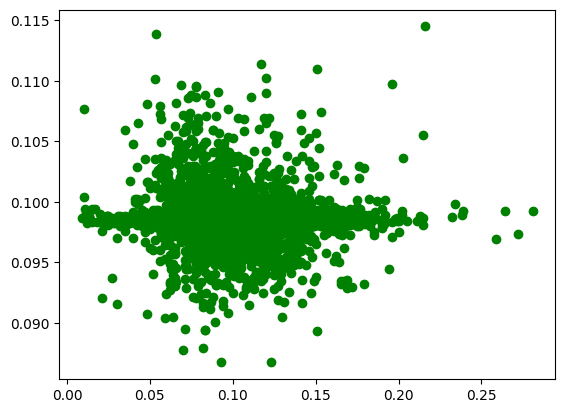

In [43]:
#Test Data

oof = pd.DataFrame(oof)
oof.columns = ['pred']
oof_xgb = pd.DataFrame(oof_xgb)
oof_xgb.columns = ['pred_xgb']
rmse=sqrt(mean_squared_error(train_target,oof['pred']))
print('lgbm OOF: '+ str(rmse))

rmse_xgb=sqrt(mean_squared_error(train_target,oof_xgb['pred_xgb']))
print('xgb OOF: '+ str(rmse_xgb))
plt.scatter(train_target, oof['pred'], color = "green")



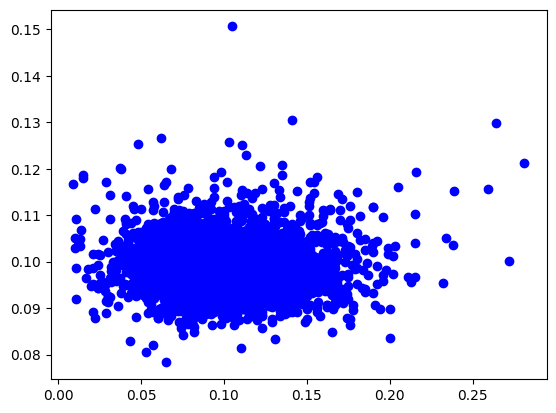

In [44]:
plt.scatter(train_target, oof_xgb['pred_xgb'], color = "blue")

# Hold Out data validation

lgbm Hold Out0.024230805799471372
xgb Hold Out0.025025868600642907


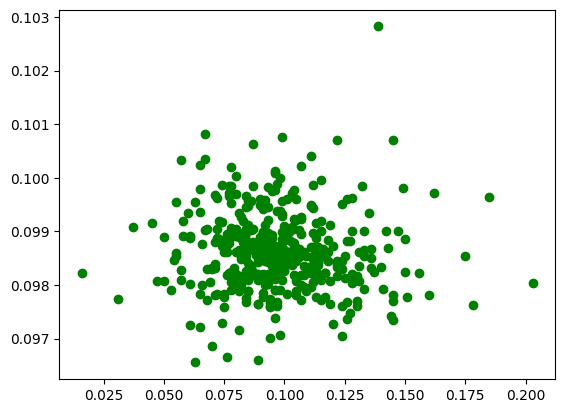

In [45]:
rmse=sqrt(mean_squared_error(hold_out_target,hold_out_pred_lgbm))
rmse_xgb=sqrt(mean_squared_error(hold_out_target,hold_out_pred_xgb))
print('lgbm Hold Out'+str(rmse))
print('xgb Hold Out'+str(rmse_xgb))

plt.scatter(hold_out_target, hold_out_pred_lgbm, color = "green")

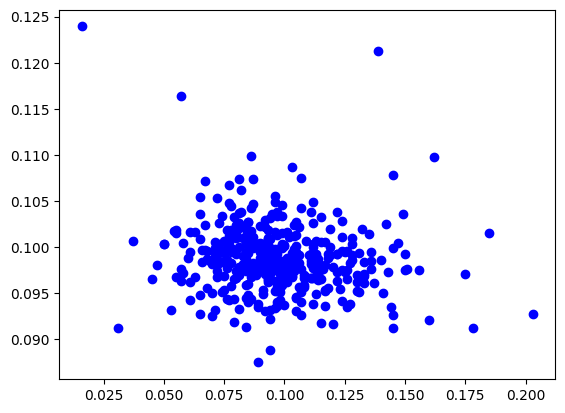

In [46]:

plt.scatter(hold_out_target, hold_out_pred_xgb, color = "blue")

# Plot of predicted diabetes prevalance with true prevelance

In [47]:
train = train.reset_index(drop=True)
train_target = train_target.reset_index(drop=True)
hold_out = hold_out.reset_index(drop=True)
hold_out_target = hold_out_target.reset_index(drop=True)
hold_out_pred_lgbm = hold_out_pred_lgbm.reset_index(drop=True)
hold_out_pred_xgb = hold_out_pred_xgb.reset_index(drop=True)
train['pred'] = oof['pred']
train['pred_xgb'] = oof_xgb['pred_xgb']
train['target'] = train_target 
hold_out['pred'] = hold_out_pred_lgbm
hold_out['pred_xgb'] = hold_out_pred_xgb
hold_out['target'] =  hold_out_target
hold_out = hold_out.reset_index(drop=True)

In [48]:
train_all =  pd.concat([train,hold_out],axis=0)
train_all = train_all.reset_index(drop=True)

In [49]:
from collections import defaultdict
import numpy as np

def calc_percentages_per_county(cali_sample, data, pct_key):
    counties_tracts = cali_sample[['TRACTFIPS', 'COUNTYFIPS', 'COUNTY']]

    tracts_to_counties = dict(zip(counties_tracts['TRACTFIPS'], counties_tracts['COUNTYFIPS']))
    geos_to_diabetes_pct = dict(zip(data['geo'], data[pct_key]))

    geos = [geo for geo in geos_to_diabetes_pct.keys()]
    # Need to make sure it is in the set of valid geos
    filtered_geos = list(filter(lambda geo: geo in tracts_to_counties, geos))

    # There are many tract_fips to less counties (we will plot the counties below) 
    diabetes_pcts = defaultdict(lambda: [])
    for geo in filtered_geos:
        county = tracts_to_counties[geo]
        diabetes_pcts[county].append(geos_to_diabetes_pct[geo])

    # Take the mean of all the tracts to get county level
    avg_diabetes_pcts = {}
    for geo in diabetes_pcts.keys():
        avg_diabetes_pcts[geo] = np.mean(diabetes_pcts[geo])
        
    return avg_diabetes_pcts

In [50]:
avg_diabetes_pcts = calc_percentages_per_county(cali_sample, train_all, 'target')
avg_diabetes_pcts_pred = calc_percentages_per_county(cali_sample, train_all, 'pred')
avg_diabetes_pcts_xgb = calc_percentages_per_county(cali_sample, train_all, 'pred_xgb')

In [51]:
# was a few steps for me to install all deps
# https://plotly.com/python/getting-started/
import plotly.figure_factory as ff

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

def plot_county_data(data, title='% by county'):
    # Get all county ids
    county_ids = data.keys()
    # scale to 100 for the plot
    county_values = [data[key] * 100.0 for key in data]

    endpts = list(np.mgrid[min(county_values):max(county_values):4j])
    colorscale = ["#0000FF", "#0000CC", "#0000AA", "#000055", "#000011"]
    fig = ff.create_choropleth(
        fips=county_ids, values=county_values, scope=['California'], show_state_data=True,
        colorscale=colorscale, binning_endpoints=endpts, round_legend_values=True,
        plot_bgcolor='rgb(229,229,229)',
        paper_bgcolor='rgb(229,229,229)',
        legend_title=title,
        county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
        exponent_format=True,
    )
    fig.layout.template = None
    fig.show()

# True Diabetes Prevalance by county

In [52]:
plot_county_data(avg_diabetes_pcts, title='Diabetes % By County')


# XGBoost Predicted Diabetes Prevalance by county

In [53]:
plot_county_data(avg_diabetes_pcts_xgb, title='Diabetes % By County Prediction')

# Underdiagnosed County
          To identfy the underdiagnosed county we took predicted prevelance rate from the out of the fold values with true prevelance where the difference is greater than 4% diabetes prevelance rate.

In [54]:
train['XGB_PREDMINUS_TRUE'] = train['pred_xgb'] - train['target'] 

<AxesSubplot:xlabel='XGB_PREDMINUS_TRUE', ylabel='Count'>

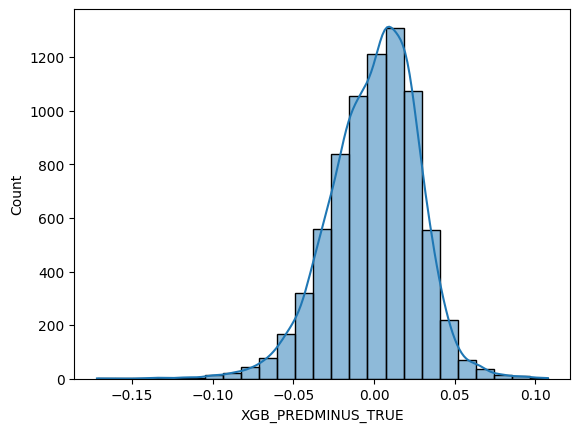

In [55]:
sns.histplot(x= "XGB_PREDMINUS_TRUE",
             data=train,
              bins=25,
              kde=True
              )

In [56]:
train = pd.merge(train,cali_sample[['TRACTFIPS','COUNTY','COUNTYFIPS']],how="left",left_on='geo', right_on='TRACTFIPS')
train.to_csv('Model_Predicted.csv')


In [67]:
underdiagnosed_county = train[train['XGB_PREDMINUS_TRUE'] > 0.04]
county_fips = train['COUNTY_y'].value_counts()
county_fips_pd = pd.DataFrame(county_fips).reset_index()
county_fips_pd.columns = ['county','Total_FIPS_Count']
county_fips_pd.head()

county  Total_FIPS_Count
0  Los Angeles County              1895
1       Orange County               531
2    San Diego County               504
3    Riverside County               374
4      Alameda County               324

# Below list of county with total fips count where the predicted diabetes prevelance is greater than 4% and possibily underdiagnosed FIPS

In [68]:
underdiagnosed_county_pd = underdiagnosed_county['COUNTY_y'].value_counts()
underdiagnosed_county_pd = pd.DataFrame(underdiagnosed_county_pd).reset_index()
underdiagnosed_county_pd.columns = ['county','Underdiagnosed_FIPS_Count']
underdiagnosed_county_all = pd.merge(underdiagnosed_county_pd,county_fips_pd,how="left",on="county")
underdiagnosed_county_all

county  Underdiagnosed_FIPS_Count  Total_FIPS_Count
0       Los Angeles County                         77              1895
1         San Diego County                         50               504
2     San Francisco County                         38               147
3           Alameda County                         26               324
4       Santa Clara County                         19               316
5            Orange County                         19               531
6        Sacramento County                         10               260
7            Placer County                          9                74
8           Ventura County                          5               129
9             Butte County                          4                45
10             Yolo County                          4                34
11         Monterey County                          3                78
12     Contra Costa County                          3               166
13           Solano County                          2                86
14  San Luis Obispo County                          2                28
15           Sonoma County                          2                76
16    Santa Barbara County                          2                61
17             Kern County                          2                85
18        San Mateo County                          2               136
19   San Bernardino County                          2               275
20           Fresno County                          2               160
21       Santa Cruz County                          1                33
22             Yuba County                          1                 7
23        Riverside County                          1               374
24        El Dorado County                          1                30